In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [6]:
# b = phoebe.load("../estimations/bundle-saves/ebai-estimates-trimmed")
b = phoebe.load("../estimations/bundle-saves/comp-LID3/ebai-estimates-trimmed")
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
allRawDatasets = rawGaiaDatasets + ['lc_iturbide_raw']

In [23]:
def printChi2(b: phoebe.Bundle, model: str):
	print(model, "-------------------------------------", sep='\n')
	try:
		print('\t', "Iturbide -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	except: pass

	try:
		print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	except: pass

	try:
		for gd in rawGaiaDatasets:
			print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))
	except: pass

In [3]:
b.set_value(qualifier='q', value=1/b.get_value(qualifier='q'))

Wed, 25 Oct 2023 15:56 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value
Wed, 25 Oct 2023 15:56 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value


100%|██████████| 1414/1414 [02:03<00:00, 11.44it/s]


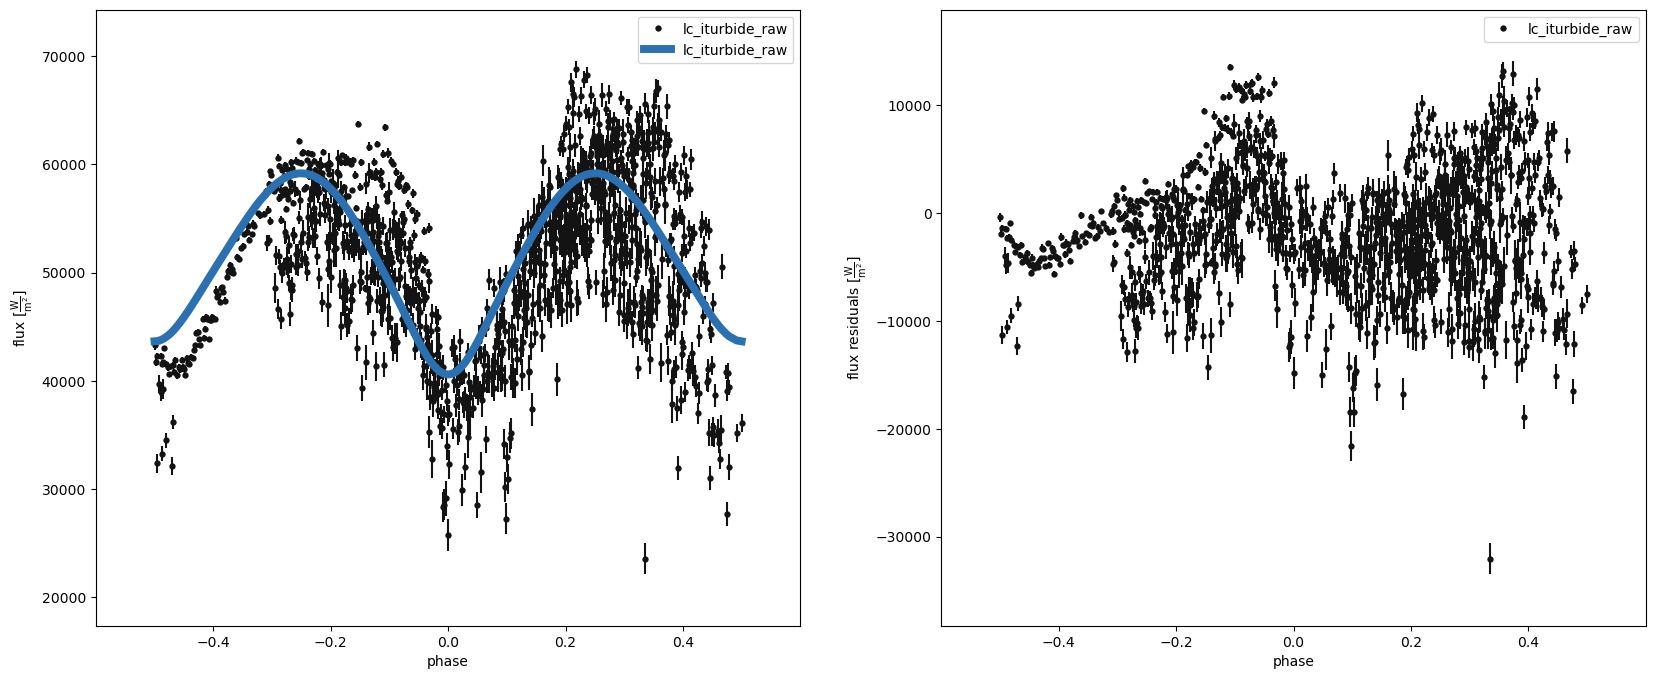

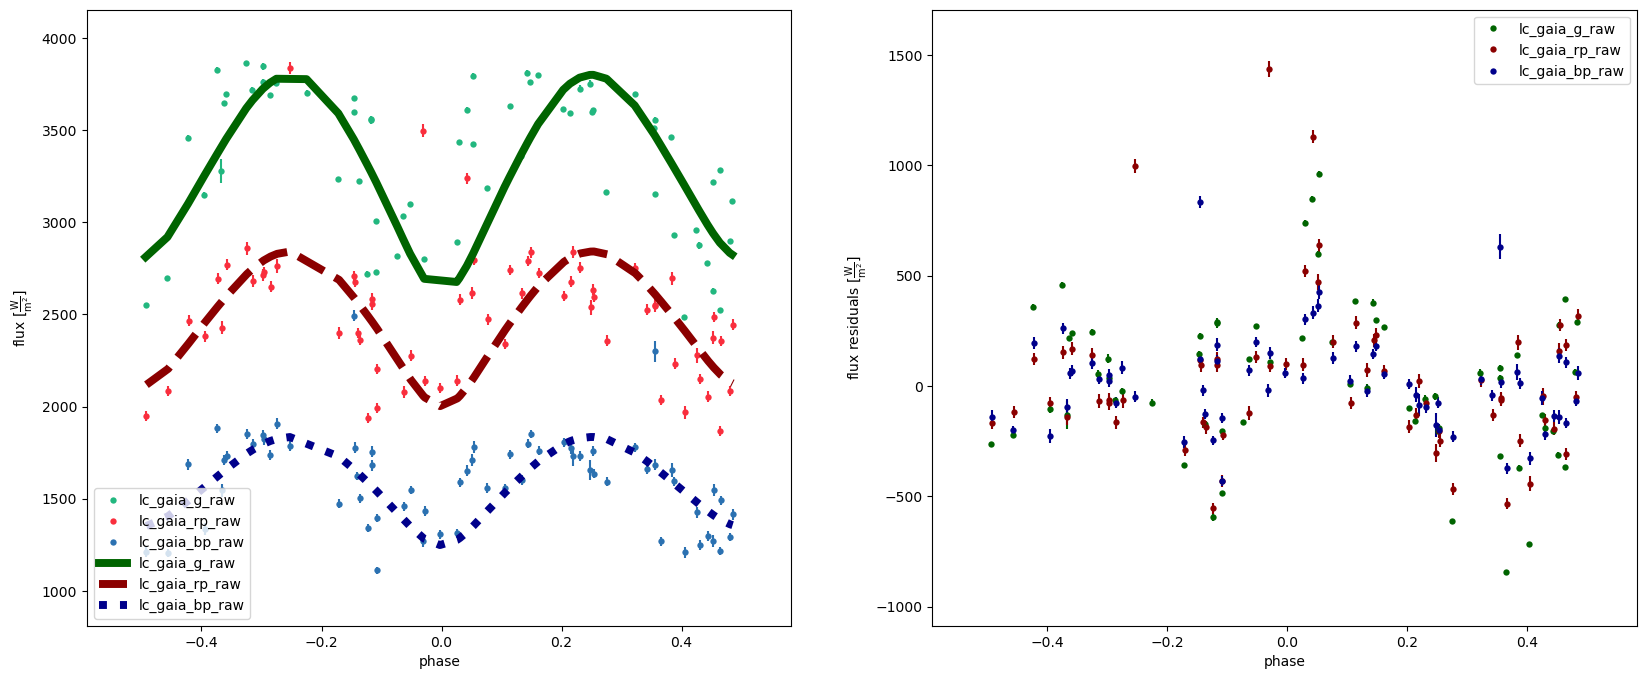

before_optimizers
-------------------------------------
	 Iturbide - 80372.91989078322
	 Gaia - 80636.76379268152
		 lc_gaia_g_raw - 68451.76819246518
		 lc_gaia_rp_raw - 8305.406739604648
		 lc_gaia_bp_raw - 3879.588860611689


In [9]:
gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='before_optimizers', overwrite=True)

gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model='before_optimizers', legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)
printChi2(b, 'before_optimizers')

## Loading Aviles Observations

Not used for optimization, but rather only for verification of current solution

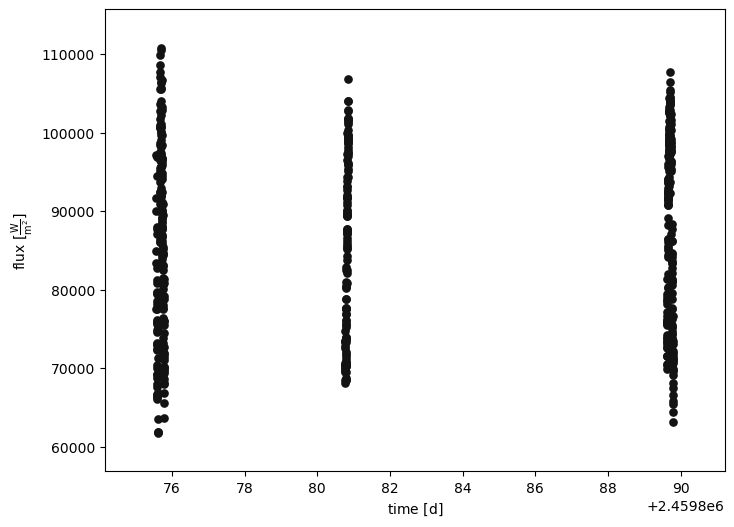

100%|██████████| 550/550 [00:47<00:00, 11.69it/s]
Wed, 25 Oct 2023 16:06 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


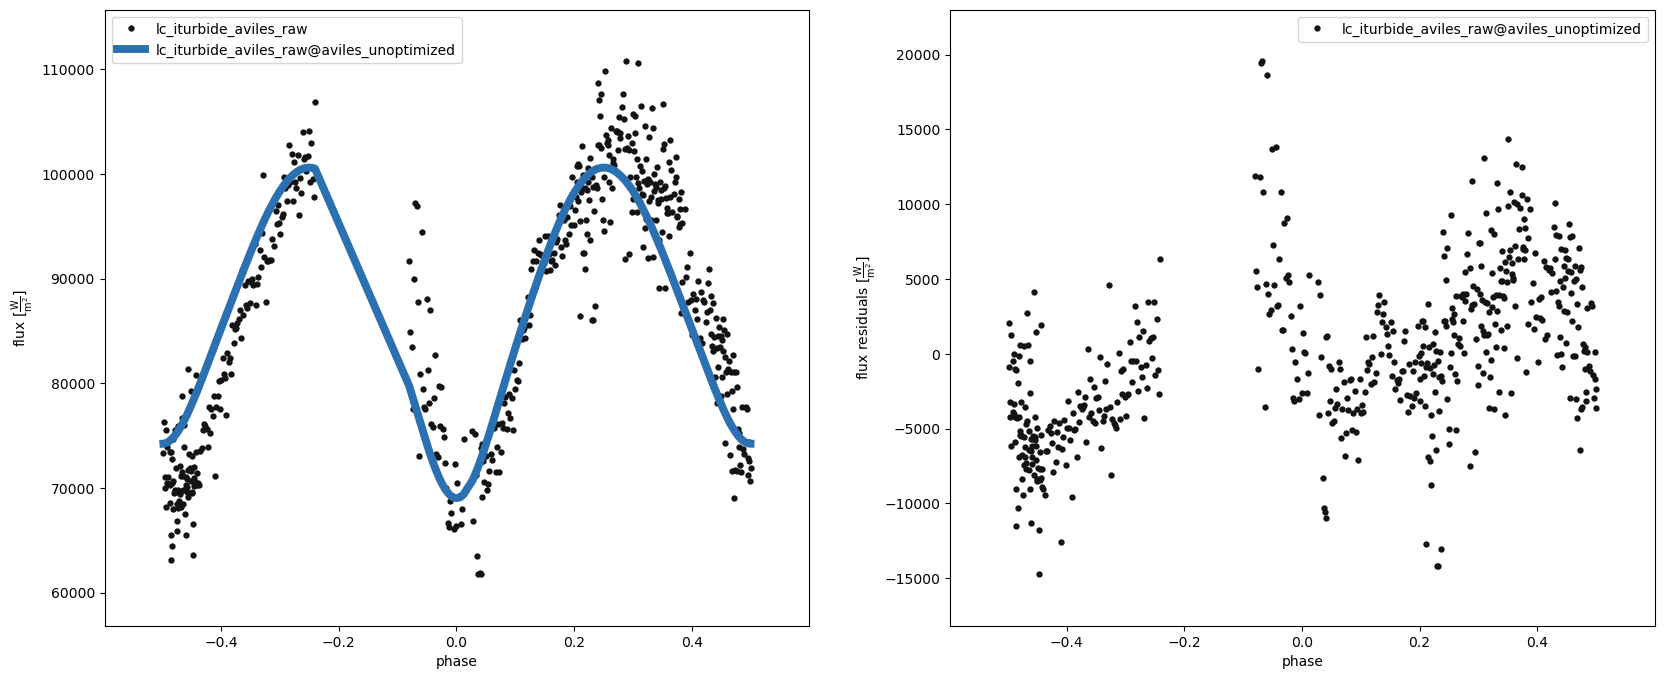

In [13]:
import pandas as pd

OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
AVILES_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide Aviles", "aviles-differential-flux.csv")

avilesObservations = pd.read_csv(AVILES_OBSERVATIONS_CSV)

b.add_dataset('lc', dataset='lc_iturbide_aviles_raw', overwrite=True,
              times=avilesObservations['julianDate'].to_numpy()*u.day, 
              fluxes=avilesObservations['flux'].to_numpy(), pblum_mode="dataset-scaled")

b.plot(dataset='lc_iturbide_aviles_raw', show=True, marker='.')

gen_utils.abilitateDatasets(b, ['lc_iturbide_aviles_raw'], False)
b.run_compute(model="aviles_unoptimized", overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=['lc_iturbide_aviles_raw'], model='aviles_unoptimized')
gen_utils.abilitateDatasets(b, b.datasets)

## Priors

Taking priors from [Poro et al. (2021)]. Using $P_{orb}$ for determining limits of adjustable parameters

In [14]:
b.flip_constraint(qualifier='mass', component='primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 3.35 solRad>

In [15]:
print(b['mass'])
print(b['q'])
print(b['sma'])
print(b['requiv'])
print(b['fillout_factor'])

ParameterSet: 3 parameters
           mass@primary@component: 2.4681169739124 solMass
C        mass@secondary@component: 2.065178646940008 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 0.8367426134047191
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@comp

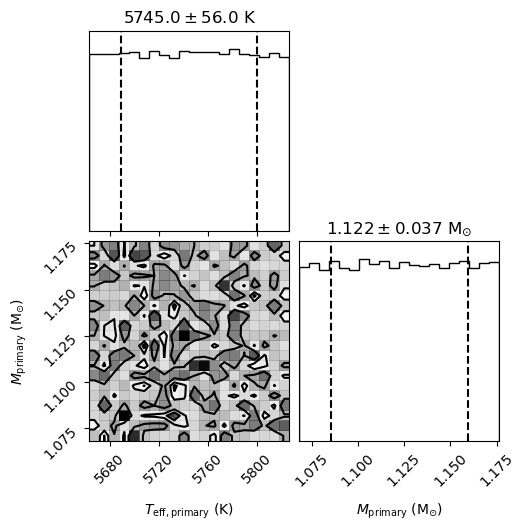

In [16]:
# Poro et al. (2021) [Investigation of P_orb and other params relationships]
# using uninformative uniform priors; mainly looking to restrict optimizer parameter space
p_orb = b.get_value(qualifier='period', component='binary')

# primary T_eff
upperTeffPrimary = (6951.42 + 112.16)*p_orb + (3426.01 + 44.12)
lowerTeffPrimary = (6951.42 - 112.68)*p_orb + (3426.01 - 43.90)

# primary mass
upperMassPrimary = (2.924 + 0.075)*p_orb + (0.147 + 0.029)
lowerMassPrimary = (2.924 - 0.075)*p_orb + (0.147 - 0.029)

b.add_distribution({
	'teff@primary': phoebe.uniform(high=upperTeffPrimary, low=lowerTeffPrimary, unit=u.K),
	'mass@primary': phoebe.uniform(high=upperMassPrimary, low=lowerMassPrimary, unit=u.solMass)
}, distribution='poro_porb_bounds', overwrite_all=True)

_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

## Period and `t0_supconj`

In [27]:
# opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], label='period_t0', export=True, datasets=allRawDatasets, subfolder="differential-norm-estimates", maxiter=150)
opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], label='period_t0', export=True, datasets=allRawDatasets, subfolder="poro-priors", priors=['poro_porb_bounds'], maxiter=200)
# opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], 'period_t0', False, allRawDatasets, maxiter=100)

External Solver: ./external-jobs/poro-priors/optimizer.nelder_mead_opt_period_t0.py ./results/opt_period_t0_solution


('opt_period_t0', 'opt_period_t0_solution')

Adopted:
t0_supconj@binary@orbit@component = 0.15270 d
period@binary@orbit@component = 0.33358 d

Original values:
  t0_supconj@binary@orbit@component 0.1526964768976168 d
  period@binary@orbit@component 0.33358370778027724 d


100%|██████████| 1948/1948 [02:49<00:00, 11.51it/s]
Wed, 25 Oct 2023 16:14 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


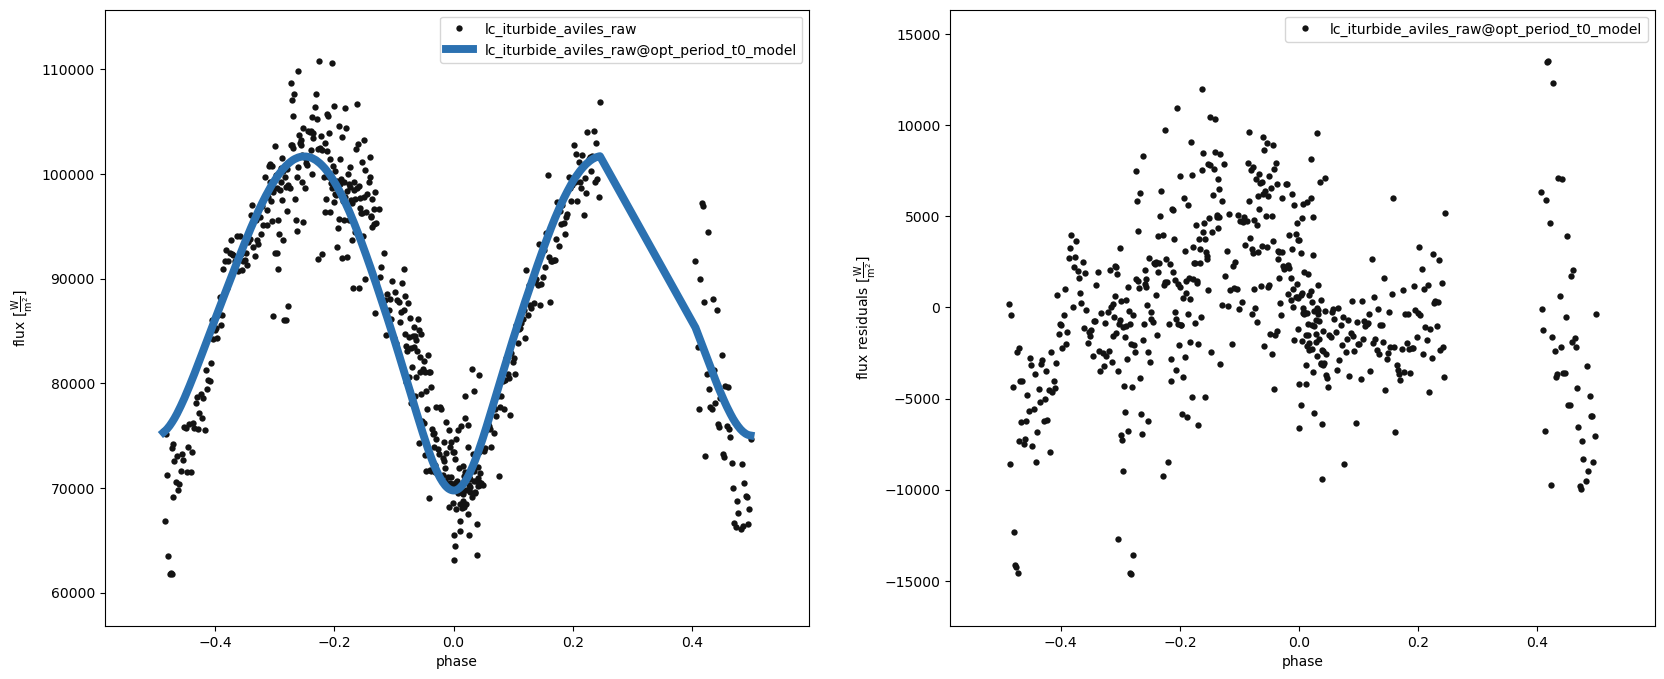

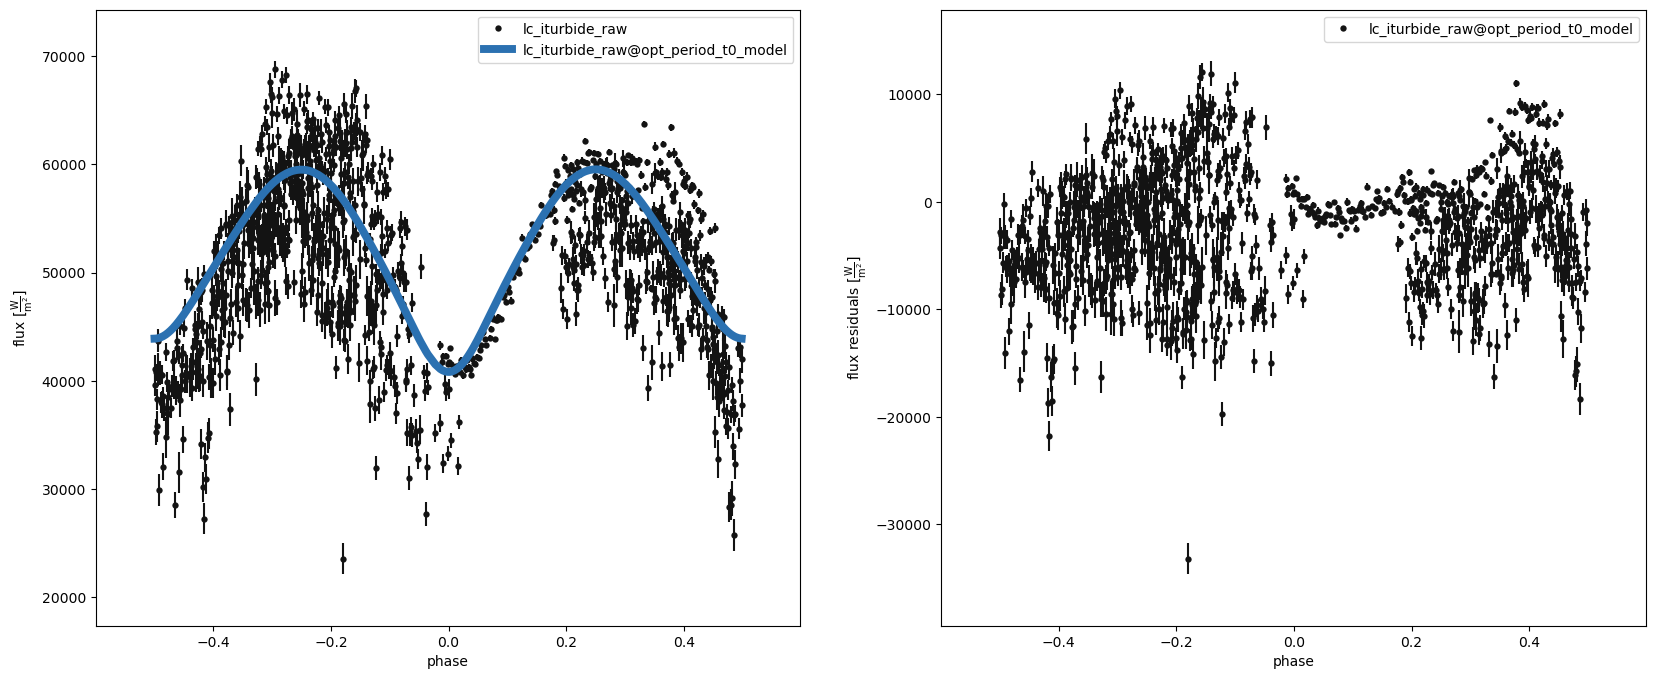

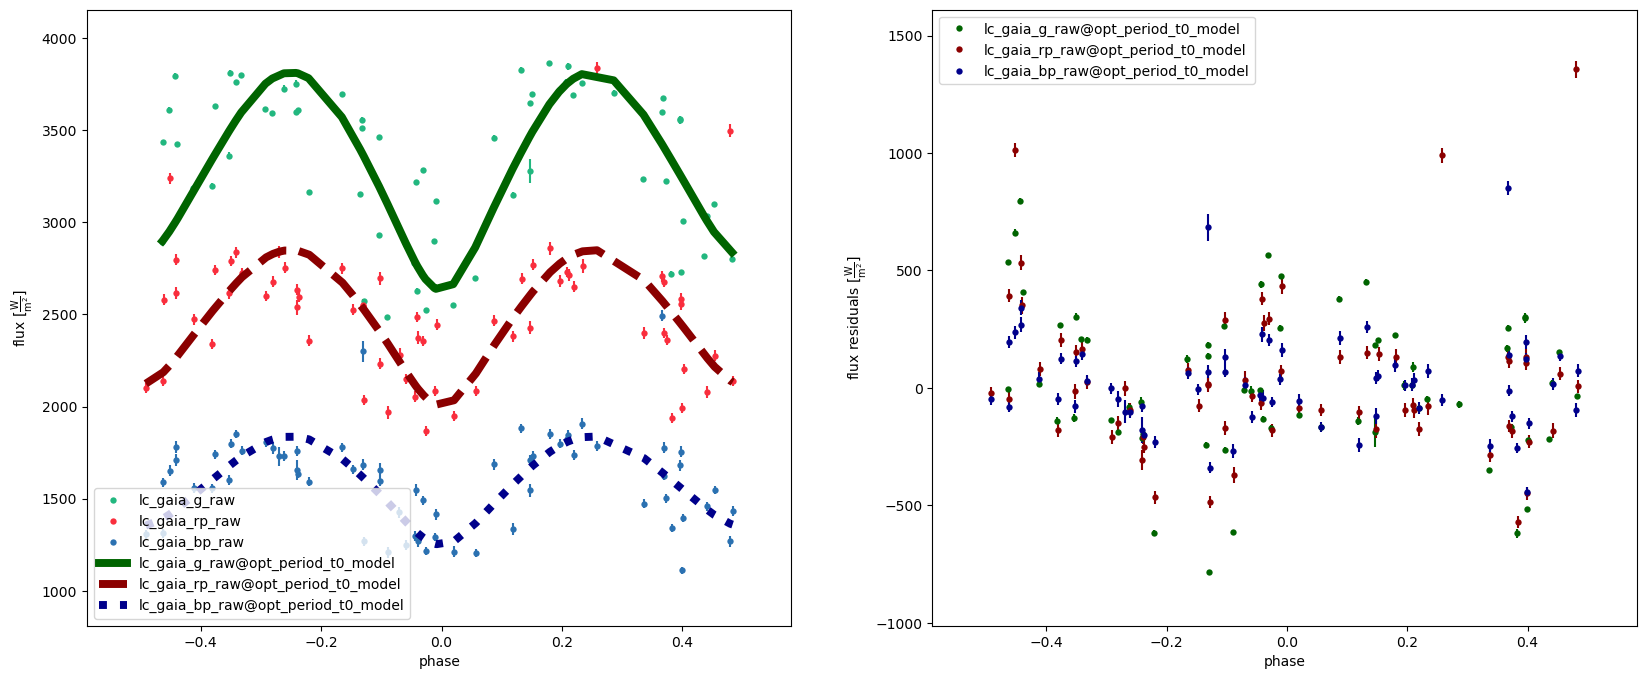

before_optimizers
-------------------------------------
	 Iturbide - 80372.91989078322
	 Gaia - 80636.76379268152
		 lc_gaia_g_raw - 68451.76819246518
		 lc_gaia_rp_raw - 8305.406739604648
		 lc_gaia_bp_raw - 3879.588860611689
opt_period_t0_model
-------------------------------------
	 Iturbide - 53773.14228630389
	 Gaia - 71524.04128715808
		 lc_gaia_g_raw - 60733.57522804268
		 lc_gaia_rp_raw - 7376.675925754388
		 lc_gaia_bp_raw - 3413.7901333610075


In [19]:
# solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
#                                                           solution_file="./external-jobs/results/opt_period_t0_solution", plot=False, 
#                                                           dataset=allRawDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, plot=False, dataset=allRawDatasets)

solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
                                                          solution_file="./external-jobs/differential-norm-estimates/results/opt_period_t0_solution", plot=False, 
                                                          dataset=allRawDatasets + ['lc_iturbide_aviles_raw'])

# solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
#                                                           solution_file="./external-jobs/poro-priors/results/opt_period_t0_solution", plot=False, 
#                                                           dataset=allRawDatasets)

gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_aviles_raw'], ['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True)

printChi2(b, 'before_optimizers')
printChi2(b, computeModelName)

## Width and depth of eclipses

* Parameters: `teffratio`, `fillout_factor`
* Will try optimizing `q` and `mass@primary` to see if they have any effect on Iturbide LC; might be worth to consider them as nuisance parameters
	* Might also work out the mismatch between the model and data at secondary eclipse

In [18]:
backup = b.copy()

In [44]:
%%script echo "skip unless need to revert back to previous state"
b = backup.copy()

In [19]:
print(b['requiv'])
print(b['requivsumfrac'])
print(b['requivratio'])
print(b['teffratio'])
print(b['mass'])
print(b['sma@binary'])
print(b['pot'])
print(b['fillout_factor'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.3943815067648717 solRad
C      requiv@secondary@component: 1.5045484111321974 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C  requivsumfrac@binary@component: 0.815434949773215
         requivsumfrac@constraint: ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component}
ParameterSet: 2 parameters
C    requivratio@binary@component: 1.0790077205075144
           requivratio@constraint: {requiv@secondary@component} / {requiv@primary@component}
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                          

### `lc_gaia_g` only

In [14]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_gaiag', subfolder="differential-norm-estimates",
						  export=True, datasets=['lc_gaia_g_raw'], maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_gaiag.py ./results/opt_teffratio_ff_gaiag_solution


('opt_teffratio_ff_gaiag', 'opt_teffratio_ff_gaiag_solution')

Adopted:
teffratio@binary@orbit@component = 0.93269 
fillout_factor@contact_envelope@envelope@component = 0.04415 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Fri, 22 Sep 2023 12:35 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [04:15<00:00,  5.52it/s]


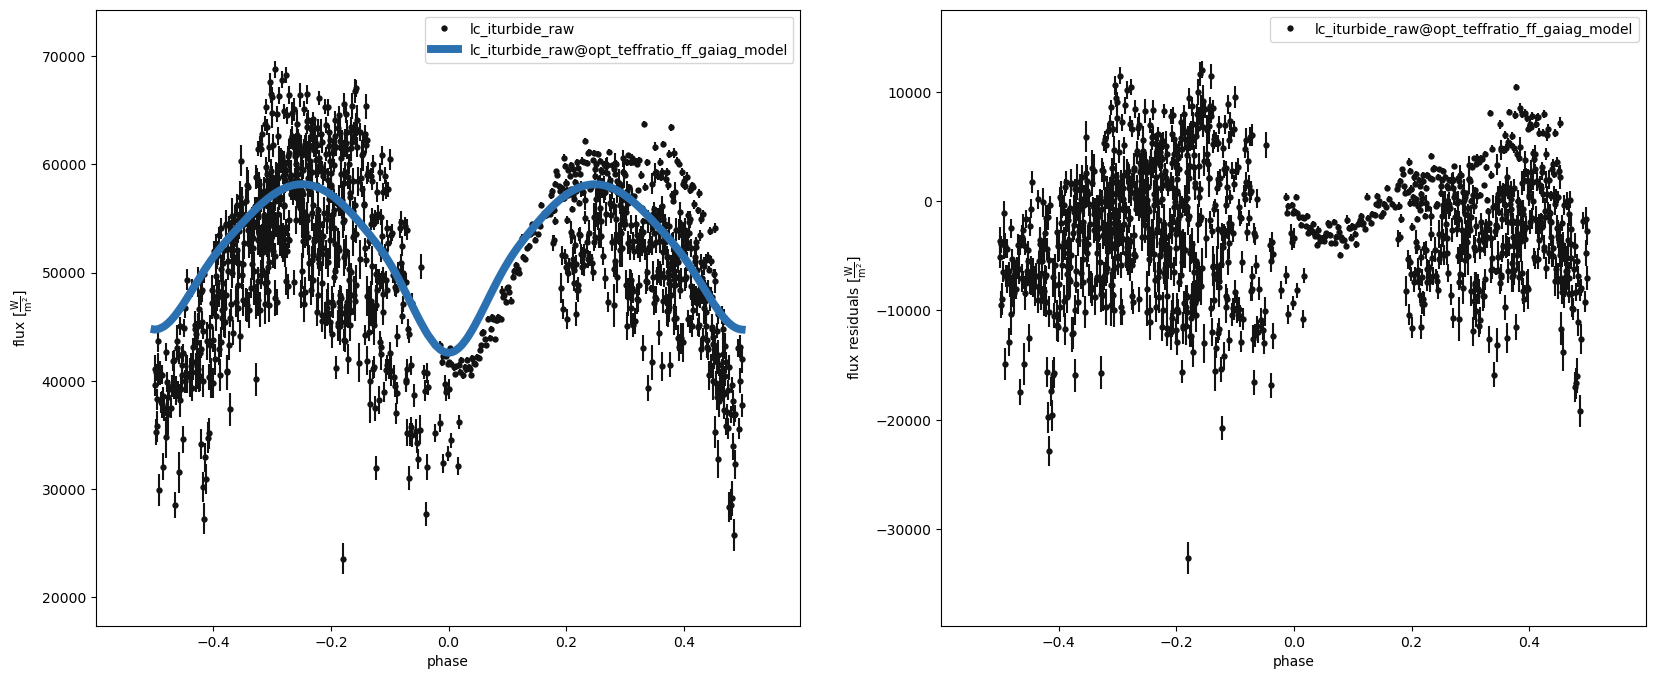

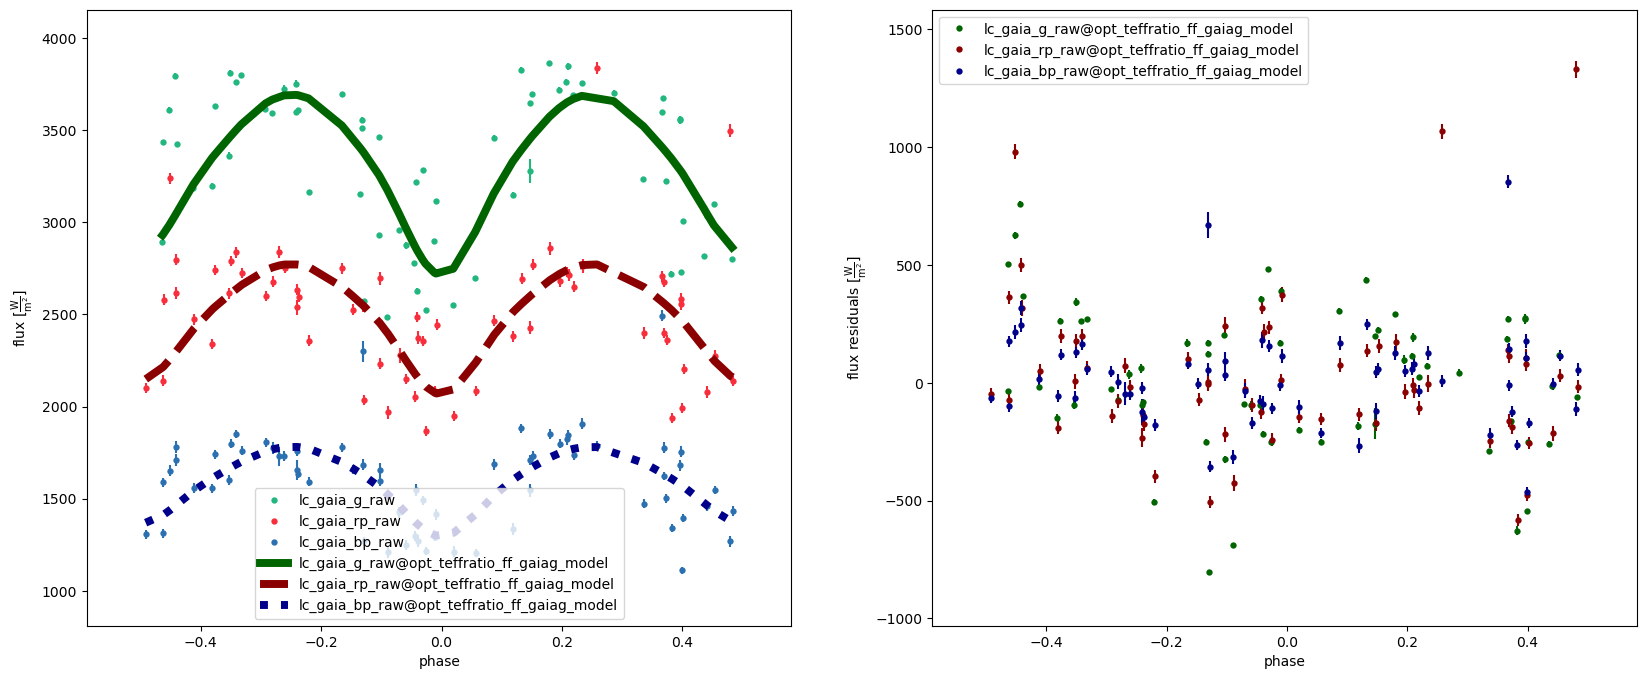

In [9]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_gaiag_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [10]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532


### `lc_iturbide` only

In [16]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_iturbide', subfolder="differential-norm-estimates",
						  export=True, datasets=['lc_iturbide_raw'], maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_iturbide.py ./results/opt_teffratio_ff_iturbide_solution


('opt_teffratio_ff_iturbide', 'opt_teffratio_ff_iturbide_solution')

Adopted:
teffratio@binary@orbit@component = 0.85438 
fillout_factor@contact_envelope@envelope@component = 0.29482 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Fri, 22 Sep 2023 12:39 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:27<00:00,  6.83it/s]


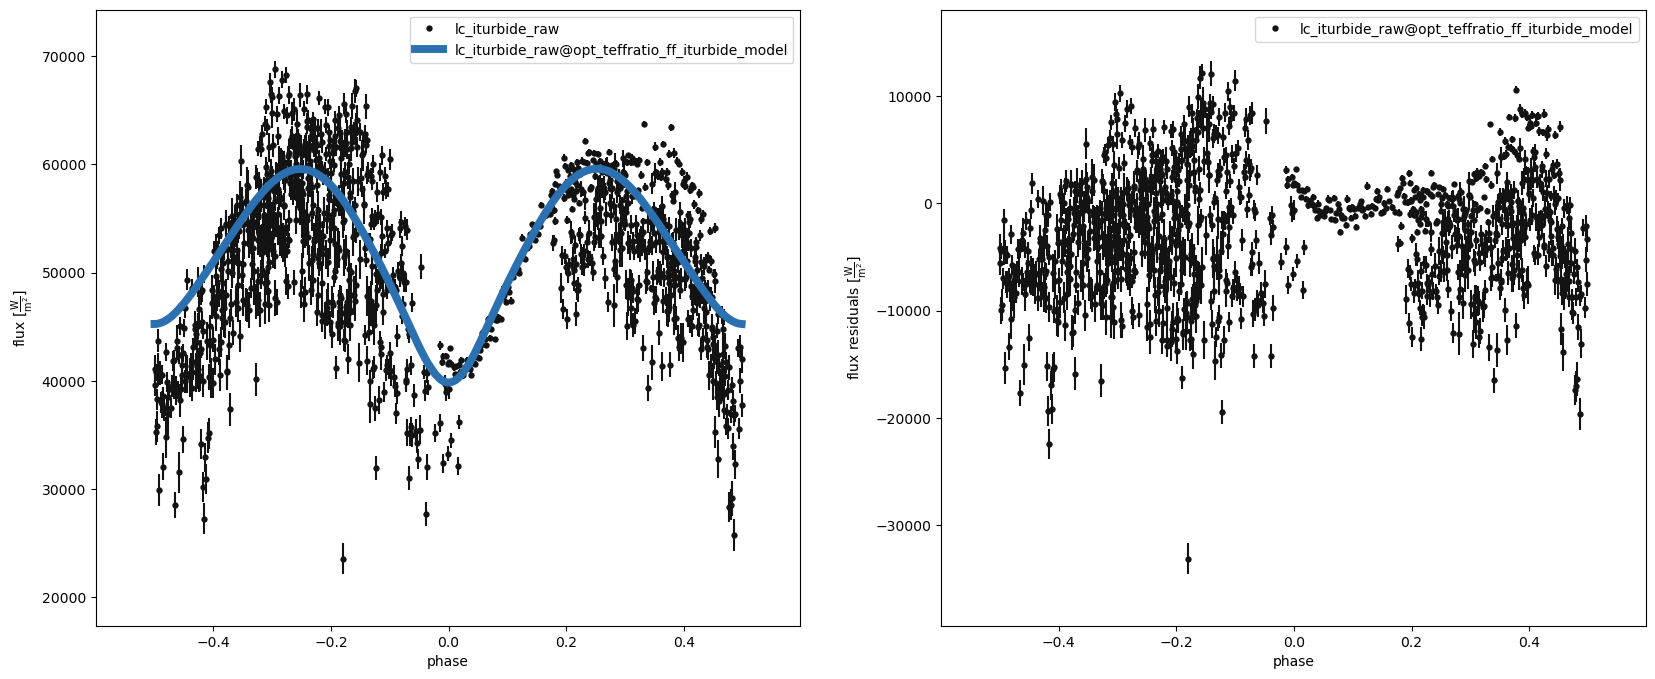

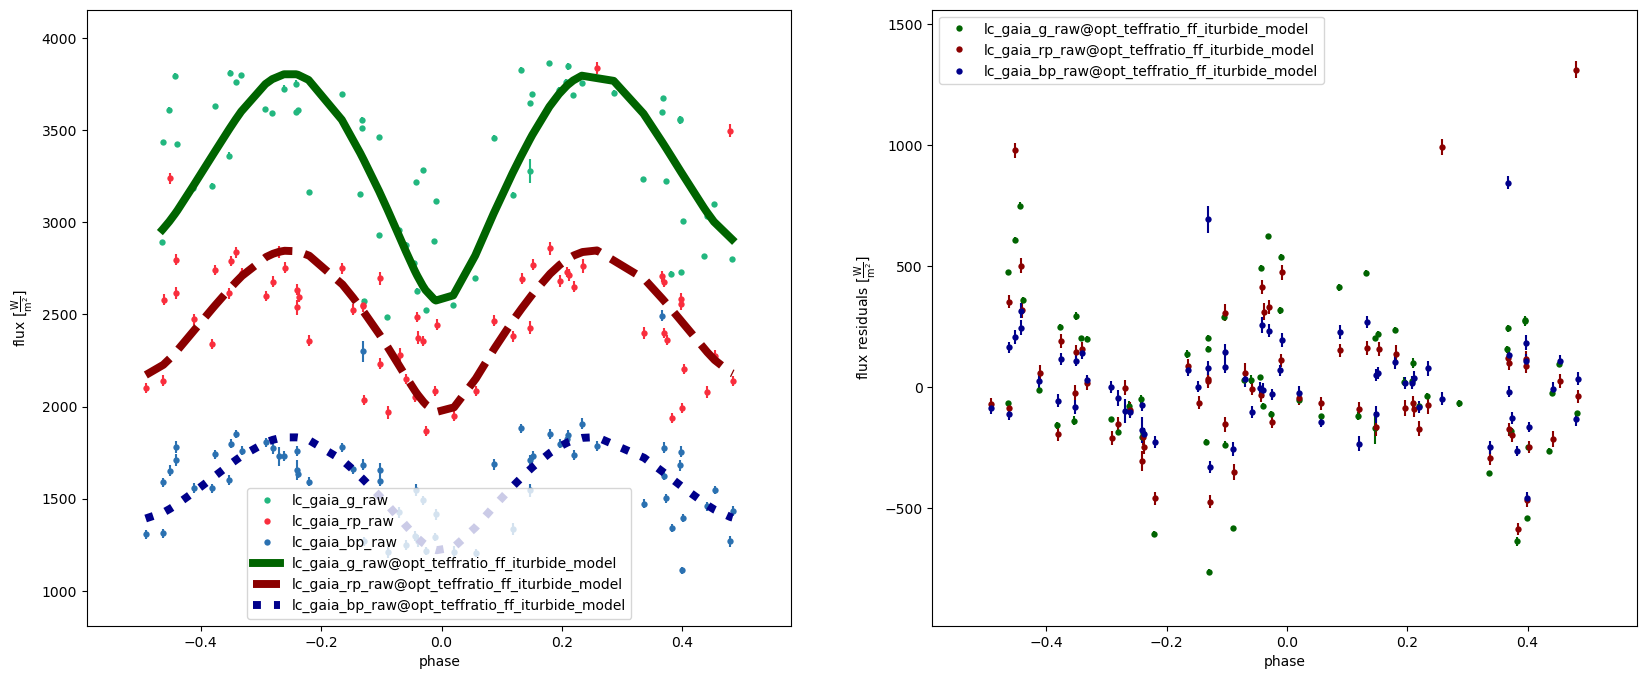

In [11]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_iturbide_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [12]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')
printChi2(b, 'opt_teffratio_ff_iturbide_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 52991.952262979496
	 Gaia - 72771.86102981483
		 lc_gaia_g_raw - 62131.844317668496
		 lc_gaia_rp_raw - 7246.9434312625235
		 lc_gaia_bp_raw - 3393.073280883809


### All datasets (Iturbide + Gaia Raw datasets)

In [20]:
%%script echo "skipping since using priors seems to prevent values from changing"
# seems like using priors prevents the optimizer from actually changing values, will try using the distribution for setting the primary's mass' initial value only
	# will omit the priors from optimizer; will likely only use them for the MCMC run

massPrimDist = b.get_value(qualifier='mass', component='primary', context='distribution')

opt_utils.optimize_params(b, ['q', 'mass@primary'], label="q_massprim", export=False, datasets=allRawDatasets, maxiter=500, priors=['poro_porb_bounds'], initial_values={'mass@primary': massPrimDist.sample()})
solutionName, computeModelName = opt_utils.adopt_solution(b, 'q_massprim', reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

skipping since using priors seems to prevent values from changing


In [21]:
massPrimDist = b.get_value(qualifier='mass', component='primary', context='distribution')

# opt_utils.optimize_params(b, ['q', 'mass@primary'], label="q_massprim_noprior", export=True, datasets=allRawDatasets, maxiter=300, 
# 						  initial_values={'mass@primary': massPrimDist.sample()}, subfolder='poro-priors')
opt_utils.optimize_params(b, ['q', 'mass@primary'], label="q_massprim_noprior", export=True, datasets=allRawDatasets, maxiter=300, 
						  initial_values={'mass@primary': massPrimDist.sample()}, subfolder='poro-priors-invertq')

External Solver: ./external-jobs/poro-priors-invertq/optimizer.nelder_mead_opt_q_massprim_noprior.py ./results/opt_q_massprim_noprior_solution


('opt_q_massprim_noprior', 'opt_q_massprim_noprior_solution')

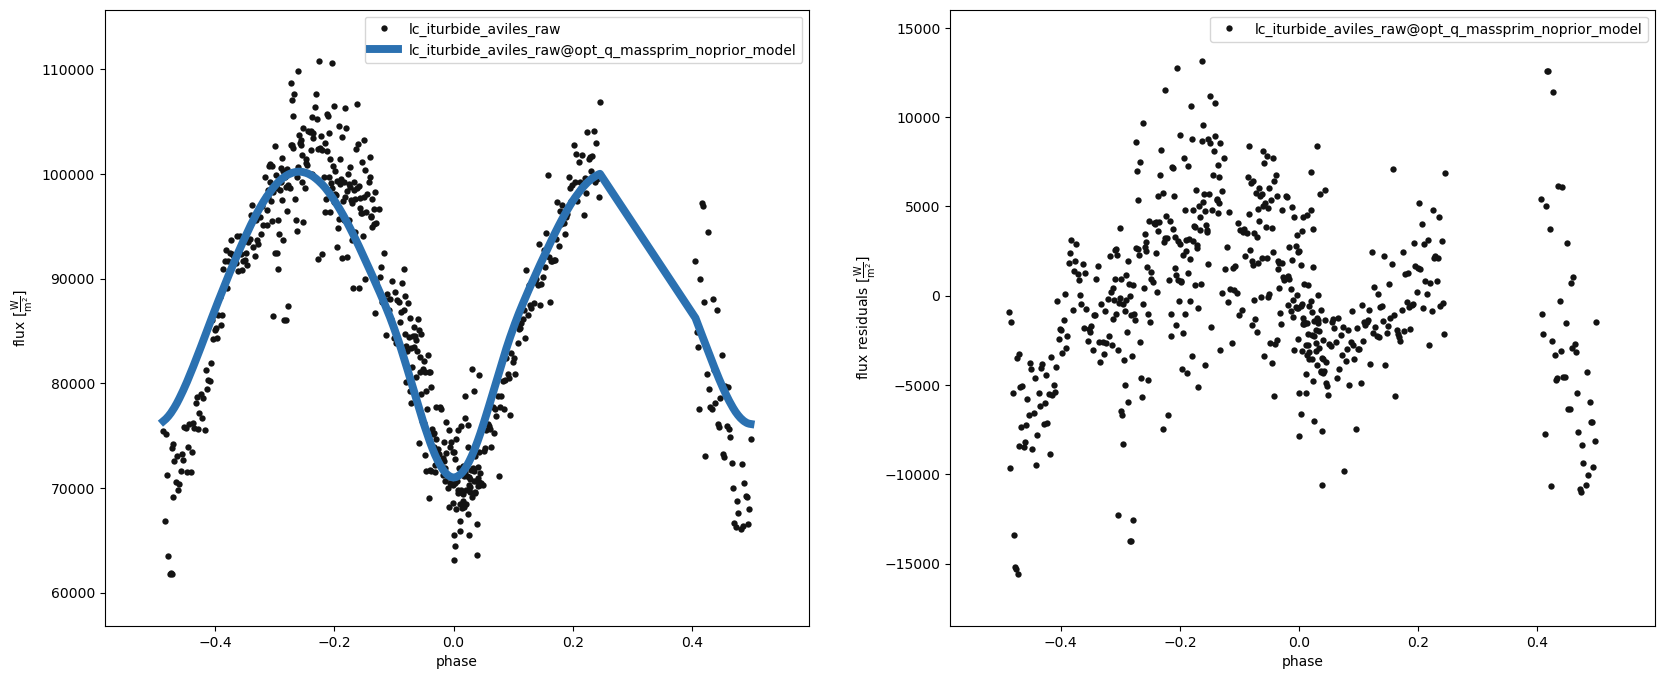

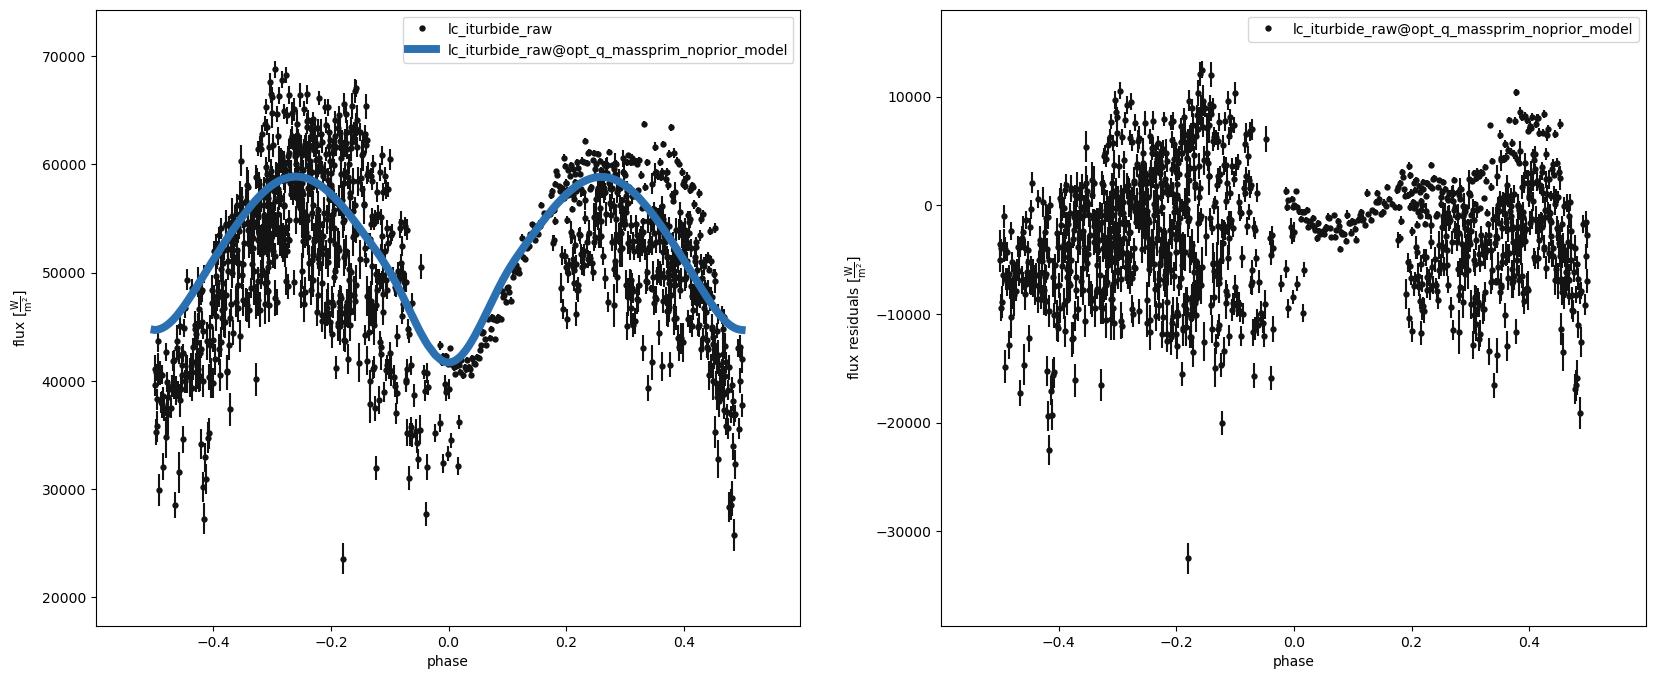

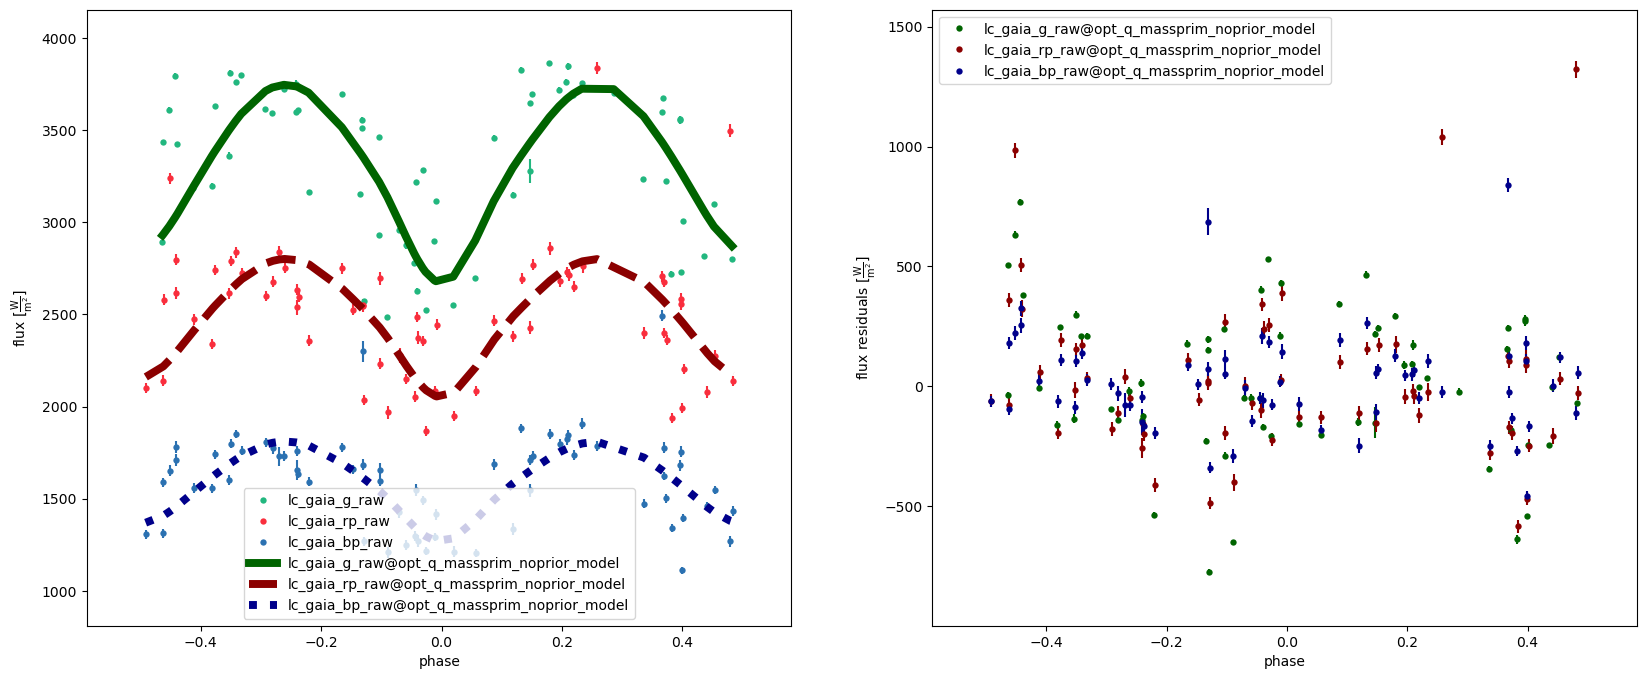

<Figure size 800x600 with 0 Axes>

/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ParameterSet: 4 parameters
           mass@primary@component: 0.294755585152102 solMass
C        mass@secondary@component: 0.9659677642308594 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0683770832767032 high=1.1764144867486253 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>
ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 5485.166234362476 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.3952841304745 high=5826.418016107988 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
ParameterSet: 4 parameters
C        requiv@primary@component: 0.6564937

In [24]:
# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/poro-priors/results/opt_q_massprim_noprior_solution', reset_params=True, plot=False)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/poro-priors-invertq/results/opt_q_massprim_noprior_solution', reset_params=False, plot=False, dataset=b.datasets)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_aviles_raw'], ['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)

print(b['mass'])
print(b['teff'])
print(b['requiv'])
print(b['sma'])

for m in b.models:
	if m != "aviles_unoptimized":
		printChi2(b, m)

In [22]:
# opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_rawdata', subfolder="differential-norm-estimates",
# 						  export=True, datasets=allRawDatasets, maxiter=250)

# opt_utils.optimize_params(b, ['teffratio', 'fillout_factor', 'q', 'mass@primary'], 'teffratio_ff_q_massprim', subfolder="poro-priors",
# 						  export=True, datasets=allRawDatasets, initial_values={'mass@primary': massPrimDist.sample()}, maxiter=400)

opt_utils.optimize_params(b, ['teffratio', 'fillout_factor', 'q', 'mass@primary'], 'teffratio_ff_q_massprim', subfolder="poro-priors-invertq",
						  export=True, datasets=allRawDatasets, initial_values={'mass@primary': massPrimDist.sample()}, maxiter=400)

External Solver: ./external-jobs/poro-priors-invertq/optimizer.nelder_mead_opt_teffratio_ff_q_massprim.py ./results/opt_teffratio_ff_q_massprim_solution


('opt_teffratio_ff_q_massprim', 'opt_teffratio_ff_q_massprim_solution')

Adopted:
teffratio@binary@orbit@component = 0.90129 
fillout_factor@contact_envelope@envelope@component = 0.14765 
q@binary@orbit@component = 1.50892 
mass@primary@star@component = 1.19741 solMass

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226
  q@binary@orbit@component 3.277182224494215
  mass@primary@star@component 0.294755585152102 solMass


100%|██████████| 1964/1964 [03:10<00:00, 10.34it/s]
Wed, 25 Oct 2023 16:35 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


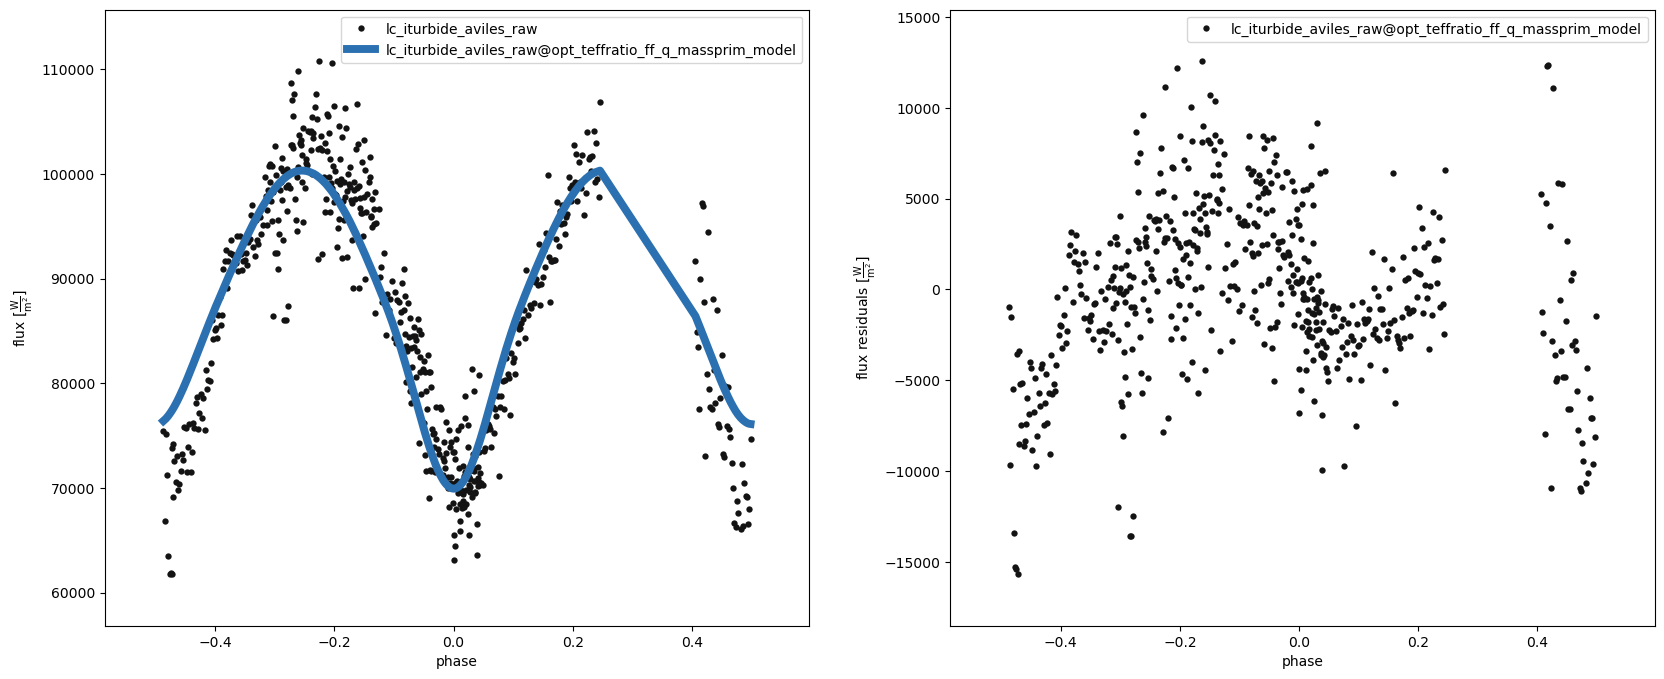

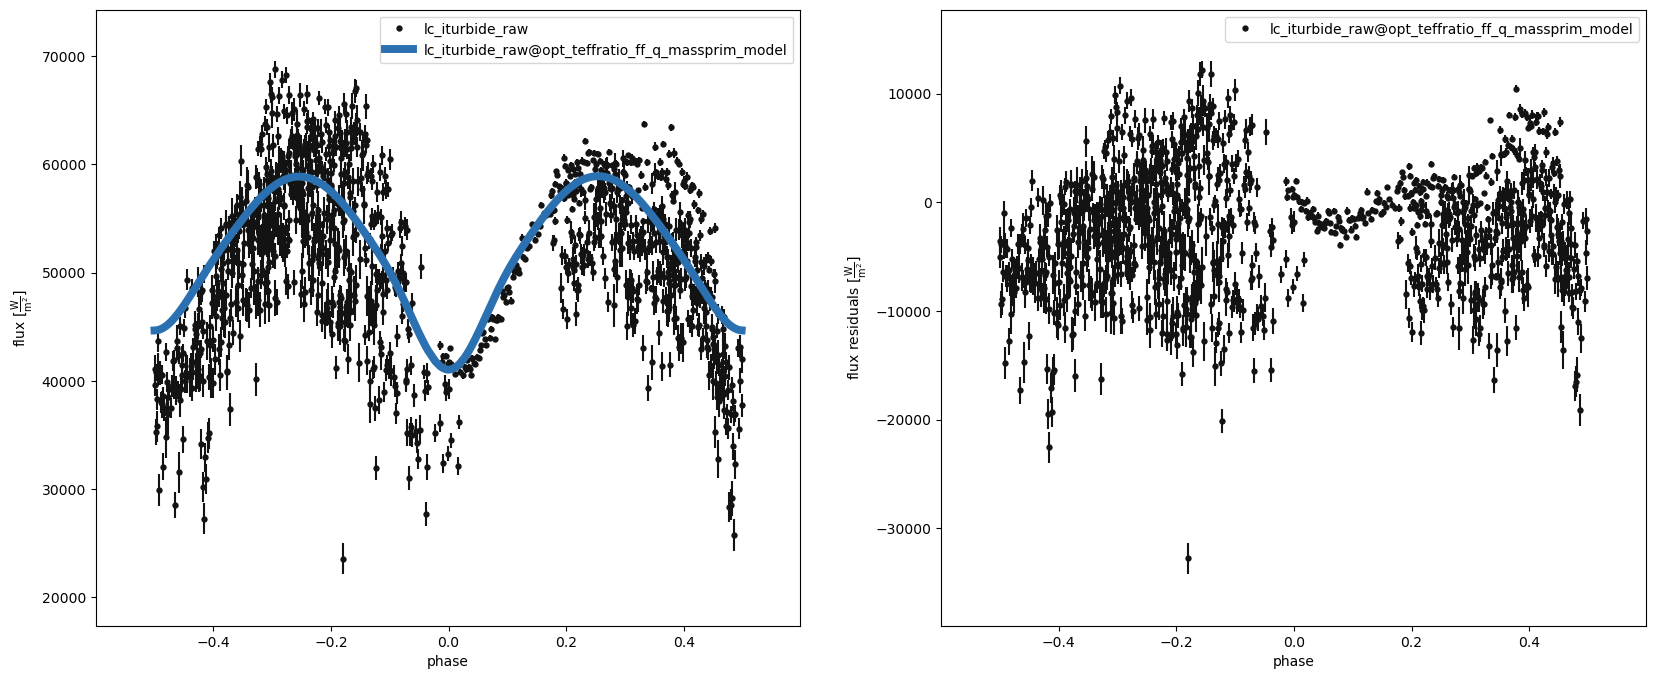

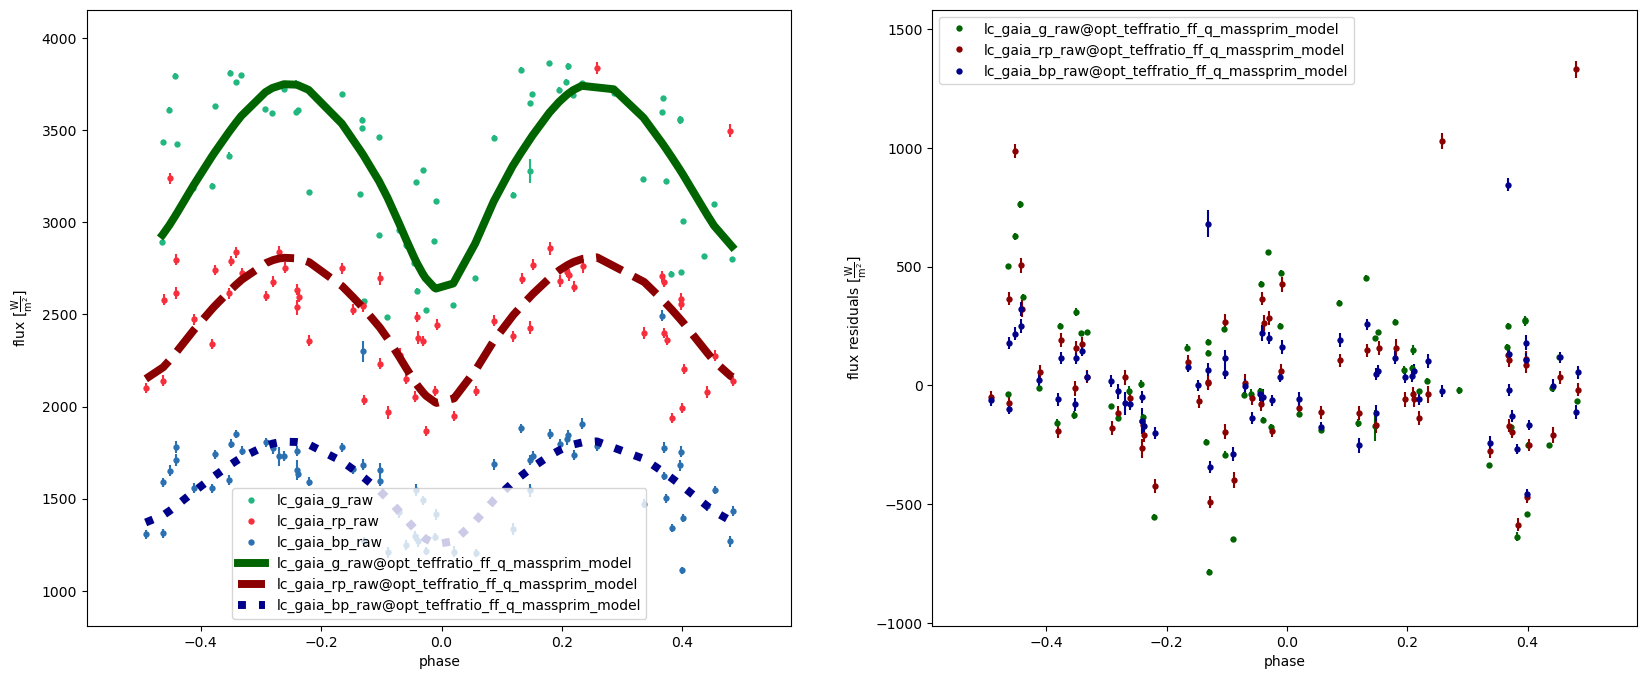

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ParameterSet: 4 parameters
           mass@primary@component: 1.1974112150045055 solMass
C        mass@secondary@component: 1.8067976621246147 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0683770832767032 high=1.1764144867486253 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>
ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 5407.756209007656 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.3952841304745 high=5826.418016107988 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
ParameterSet: 4 parameters
C        requiv@primary@component: 1.041673

In [25]:
# comparing values with below output

# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors/results/opt_teffratio_ff_q_massprim_solution", reset_params=True, plot=False)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors-invertq/results/opt_teffratio_ff_q_massprim_solution", reset_params=False, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_aviles_raw'], ['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)

print(b['mass'])
print(b['teff'])
print(b['requiv'])
print(b['sma'])

for m in b.models:
	printChi2(b, m)

Adopted:
teffratio@binary@orbit@component = 0.88006 
fillout_factor@contact_envelope@envelope@component = 0.17620 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


100%|██████████| 1414/1414 [02:03<00:00, 11.49it/s]


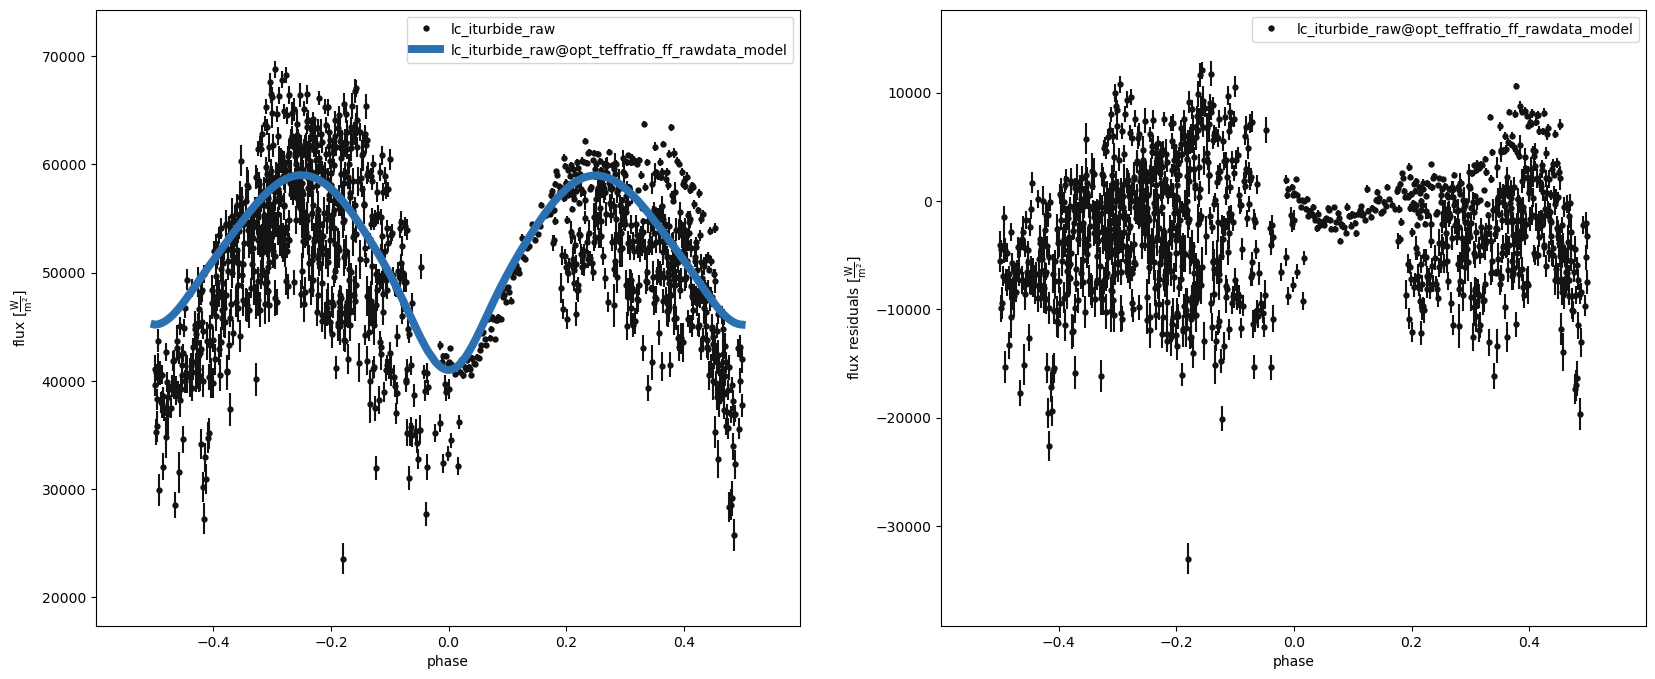

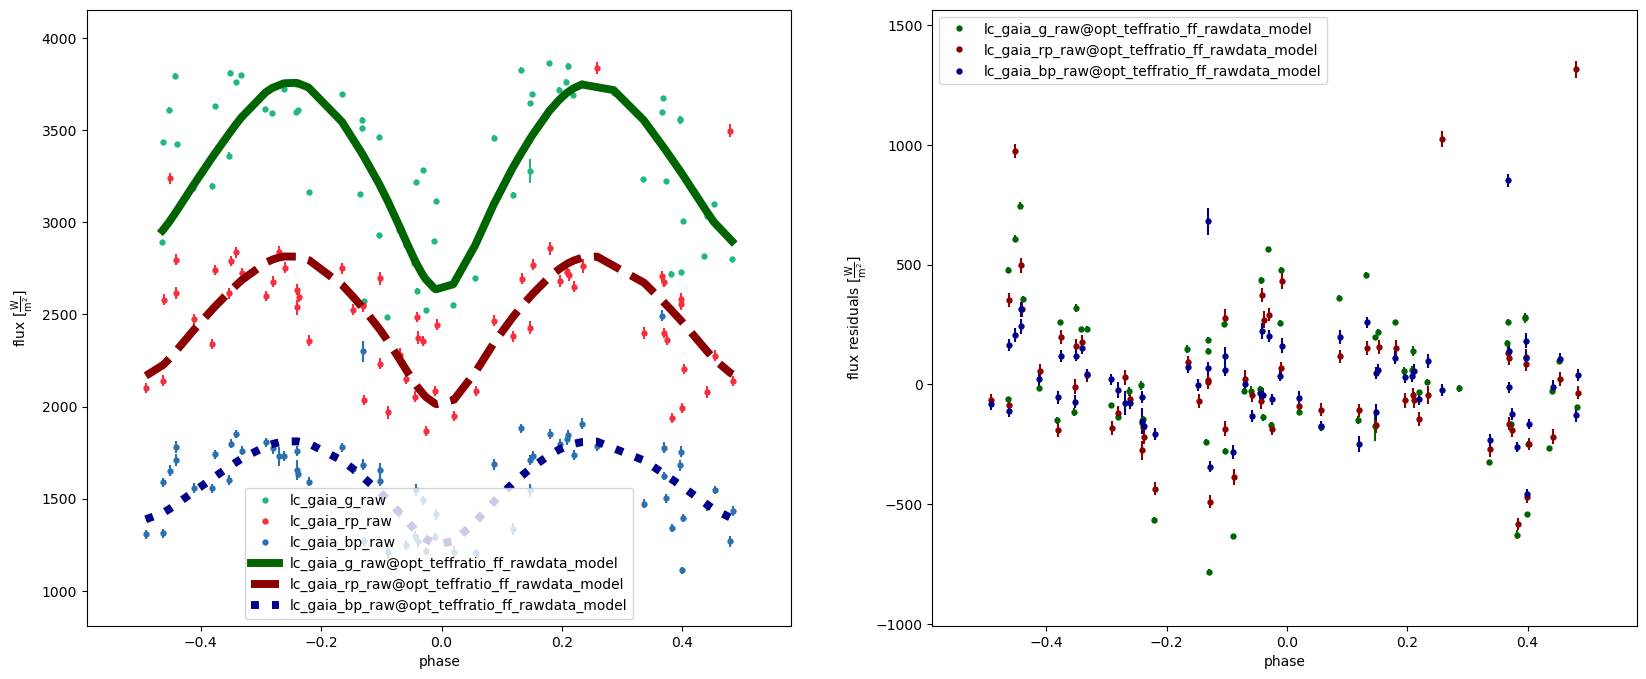

In [35]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_rawdata_solution", reset_params=True, plot=False)
# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors/results/opt_teffratio_ff_q_massprim_rawdata_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

Fri, 22 Sep 2023 12:47 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:29<00:00,  6.75it/s]


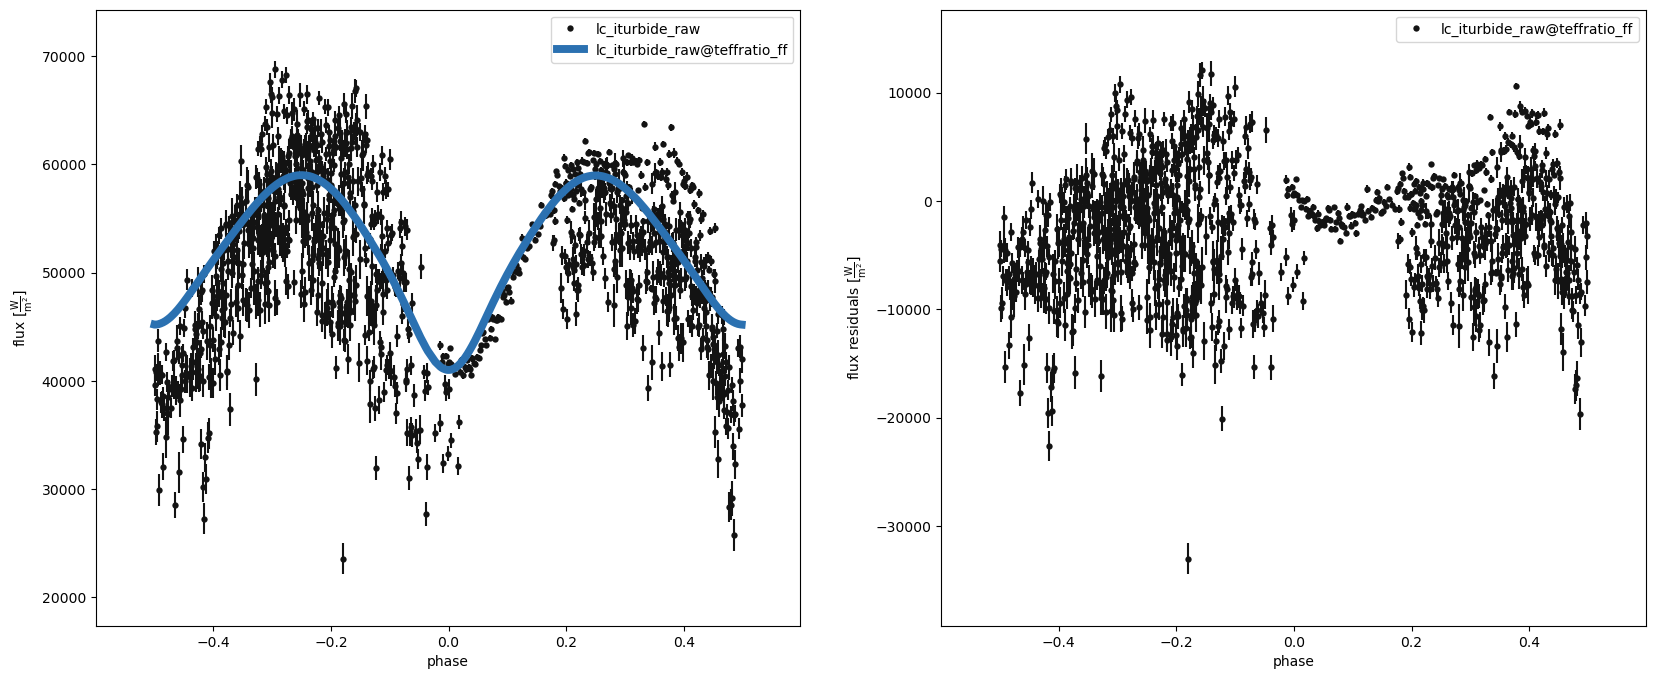

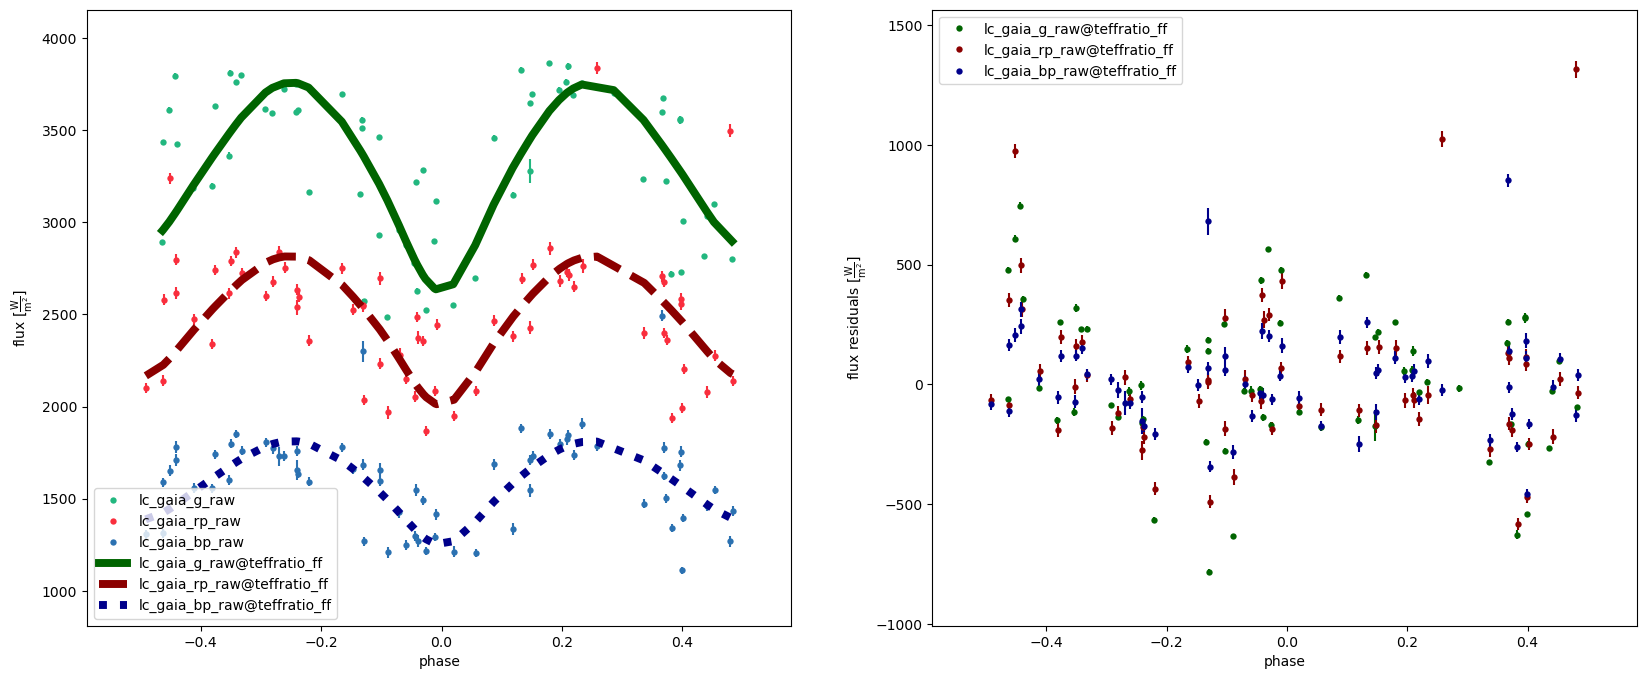

In [16]:
b.adopt_solution("opt_teffratio_ff_rawdata_solution")
b.run_compute(model="teffratio_ff", overwrite=True)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model="teffratio_ff", 
									legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [45]:
massPrimDist = b.get_value(qualifier='mass', component='primary', context='distribution')

b.set_value(qualifier='mass', component='primary', context='component', value=massPrimDist.sample())
opt_utils.optimize_params(b, ['fillout_factor', 'q', 'incl@binary'], 'ff_q_inclbin', subfolder="poro-priors-invertq", export=True, datasets=allRawDatasets, maxiter=400)

External Solver: ./external-jobs/poro-priors-invertq/optimizer.nelder_mead_opt_ff_q_inclbin.py ./results/opt_ff_q_inclbin_solution


('opt_ff_q_inclbin', 'opt_ff_q_inclbin_solution')

Adopted:
fillout_factor@contact_envelope@envelope@component = 0.14766 
q@binary@orbit@component = 1.50892 
incl@binary@orbit@component = 63.18948 deg

Original values:
  fillout_factor@contact_envelope@envelope@component 0.14764937418446294
  q@binary@orbit@component 1.508919942860078
  incl@binary@orbit@component 63.18960180037622 deg


100%|██████████| 1964/1964 [04:07<00:00,  7.95it/s]
Thu, 26 Oct 2023 11:50 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


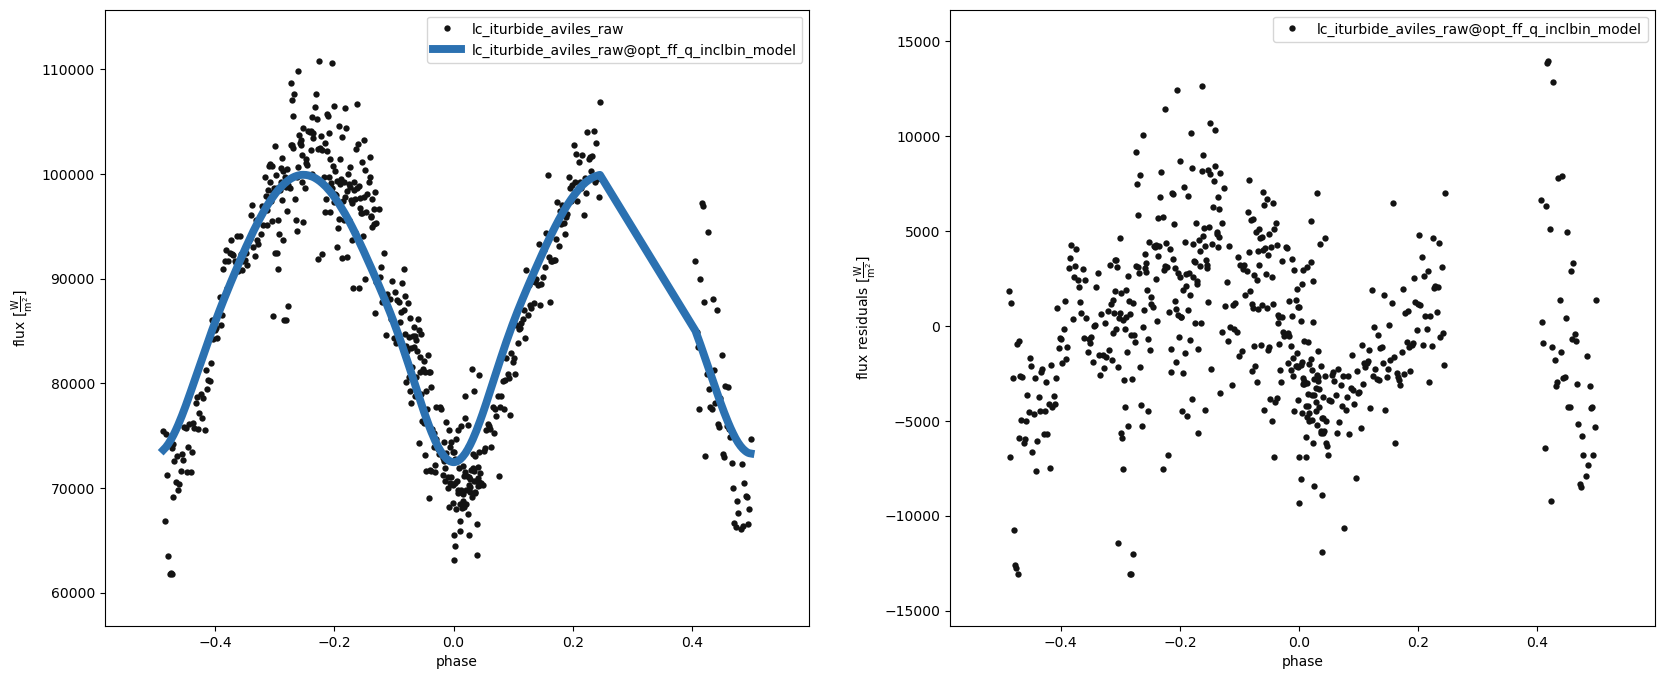

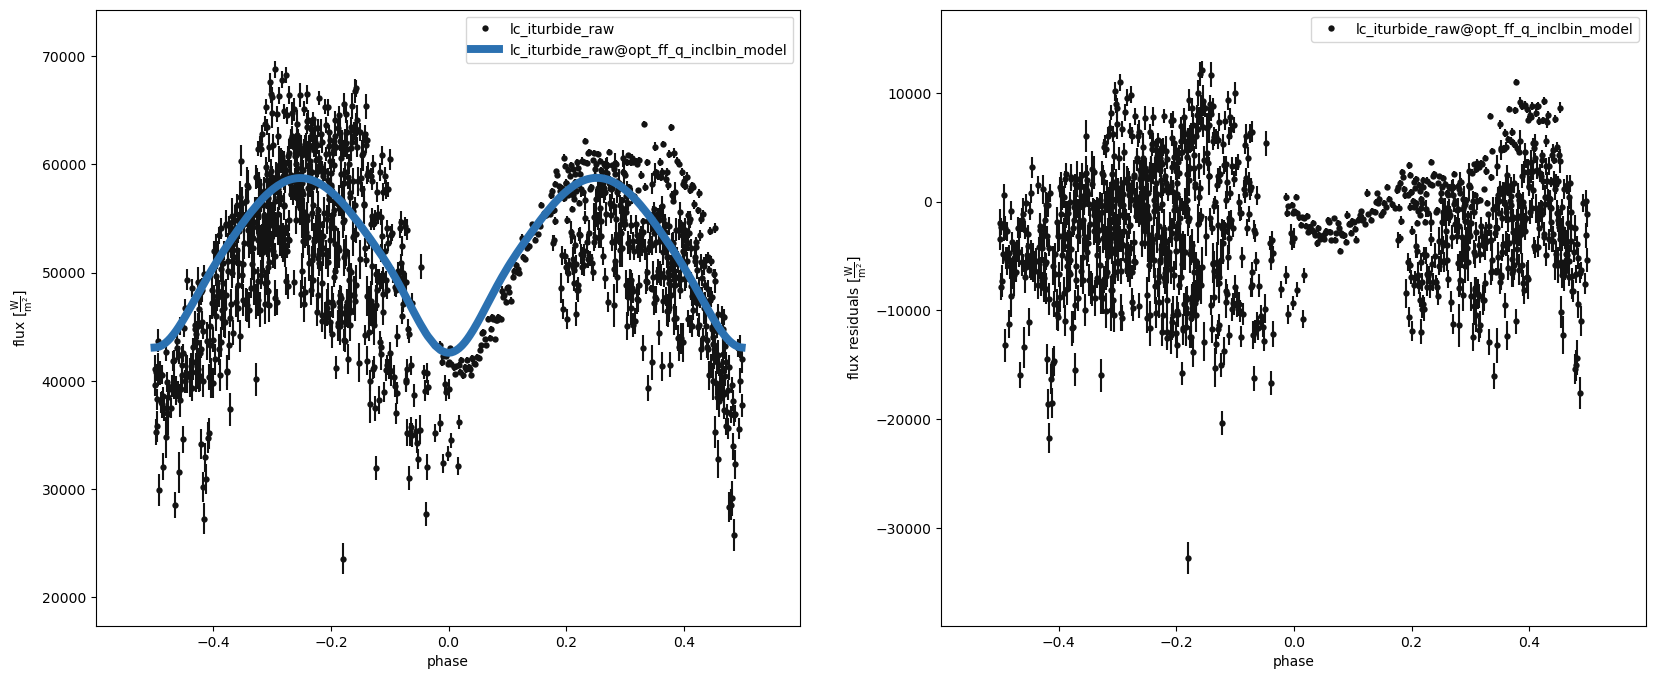

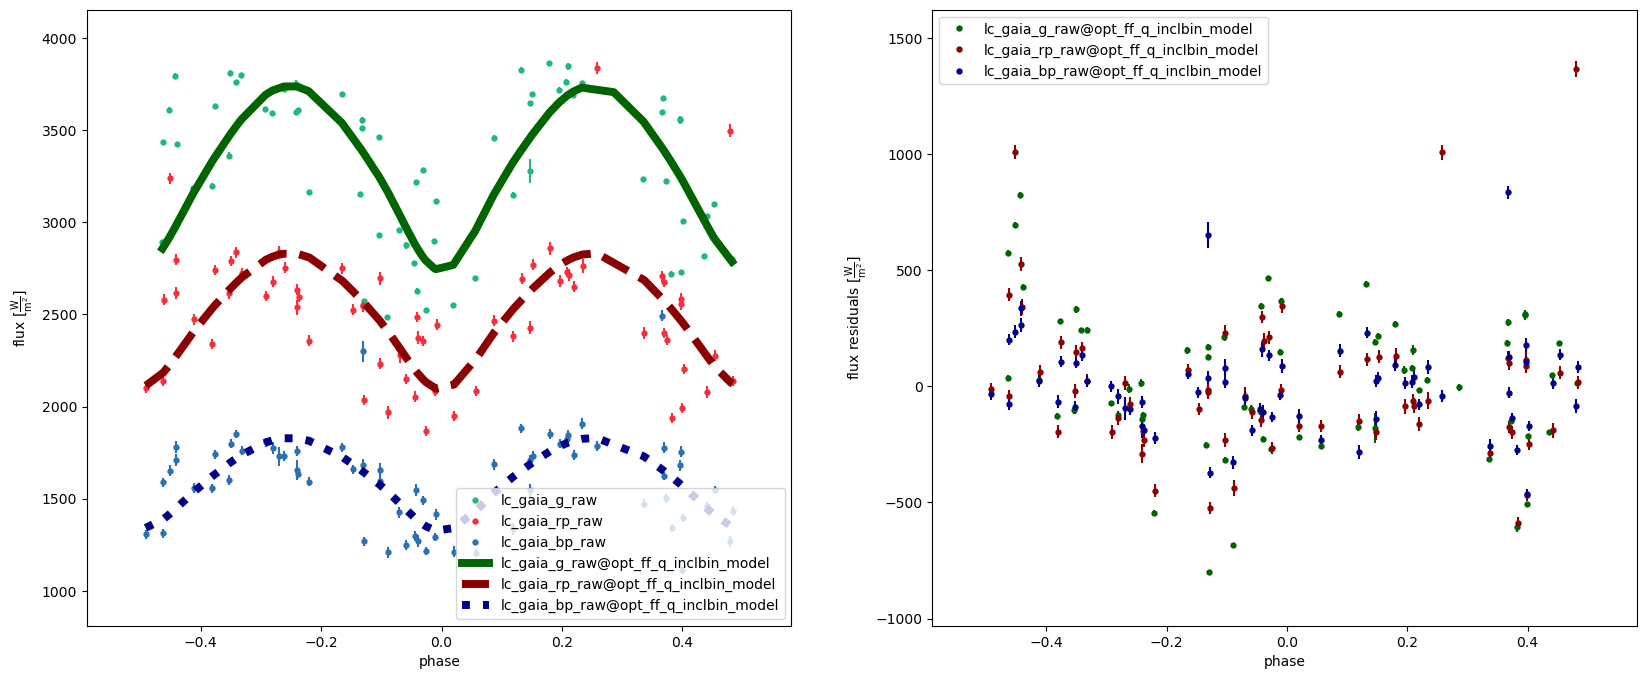

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

before_optimizers
-------------------------------------
	 Iturbide - 80372.91989078322
	 Gaia - 80636.76379268152
		 lc_gaia_g_raw - 68451.76819246518
		 lc_gaia_rp_raw - 8305.406739604648
		 lc_gaia_bp_raw - 3879.588860611689
aviles_unoptimized
-------------------------------------
opt_period_t0_model
-------------------------------------
	 Iturbide - 53773.14228630389
	 Gaia - 71524.04128715808
		 lc_gaia_g_raw - 60733.57522804268
		 lc_gaia_rp_raw - 7376.675925754388
		 lc_gaia_bp_raw - 3413.7901333610075
opt_q_massprim_noprior_model
-------------------------------------
	 Iturbide - 54432.95917682143
	 Gaia - 69296.9049461904
		 lc_gaia_g_raw - 58837.100187476426
		 lc_gaia_rp_raw - 7089.23179363449
		 lc_gaia_bp_raw - 3370.572965079494
opt_teffratio_ff_q_massprim_model
-------------------------------------
	 Iturbide - 53761.713602947864
	 Gaia - 70373.7303237192
		 lc_gaia_g_raw - 59826.04569797256
		 lc_gaia_rp_raw - 7179.9697028207775
		 lc_gaia_bp_raw - 3367.7149229258644
befo

In [49]:
# TODO: run when remote optimizer finishes

b.set_value_all(qualifier='enabled', value=True)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors-invertq/results/opt_ff_q_inclbin_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_aviles_raw'], ['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)

for m in b.models:
	printChi2(b, m)

In [31]:
# gen_utils.saveBundle(b, "dataset-scaled-optimized-pre-incl", subfolder="poro-invertq")
gen_utils.saveBundle(b, "dataset-scaled-optimized-nomass", subfolder="poro-invertq")

'bundle-saves/poro-invertq/dataset-scaled-optimized-pre-incl'

### Inclination `incl@binary`

Testing what if changing the inclination will solve the missing dip at the secondary eclipse. Testing involving `q` as a nuisance parameter as well.

In [ ]:
b = phoebe.load("./bundle-saves/poro-invertq/dataset-scaled-optimized-pre-incl")

In [29]:
print(opt_utils.optimize_params(b, ['incl@binary'], label='incl', export=True, subfolder='poro-priors-invertq', datasets=allRawDatasets), maxiter=500)
print(opt_utils.optimize_params(b, ['incl@binary', 'q'], label='incl_q', export=True, subfolder='poro-priors-invertq', datasets=allRawDatasets), maxiter=500)

External Solver: ./external-jobs/poro-priors-invertq/optimizer.nelder_mead_opt_incl.py ./results/opt_incl_solution
('opt_incl', 'opt_incl_solution')
External Solver: ./external-jobs/poro-priors-invertq/optimizer.nelder_mead_opt_incl_q.py ./results/opt_incl_q_solution
('opt_incl_q', 'opt_incl_q_solution')


Adopted:
incl@binary@orbit@component = 62.17224 deg

Original values:
  incl@binary@orbit@component 63.18960180037622 deg


100%|██████████| 1964/1964 [03:49<00:00,  8.55it/s]
Thu, 26 Oct 2023 11:54 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


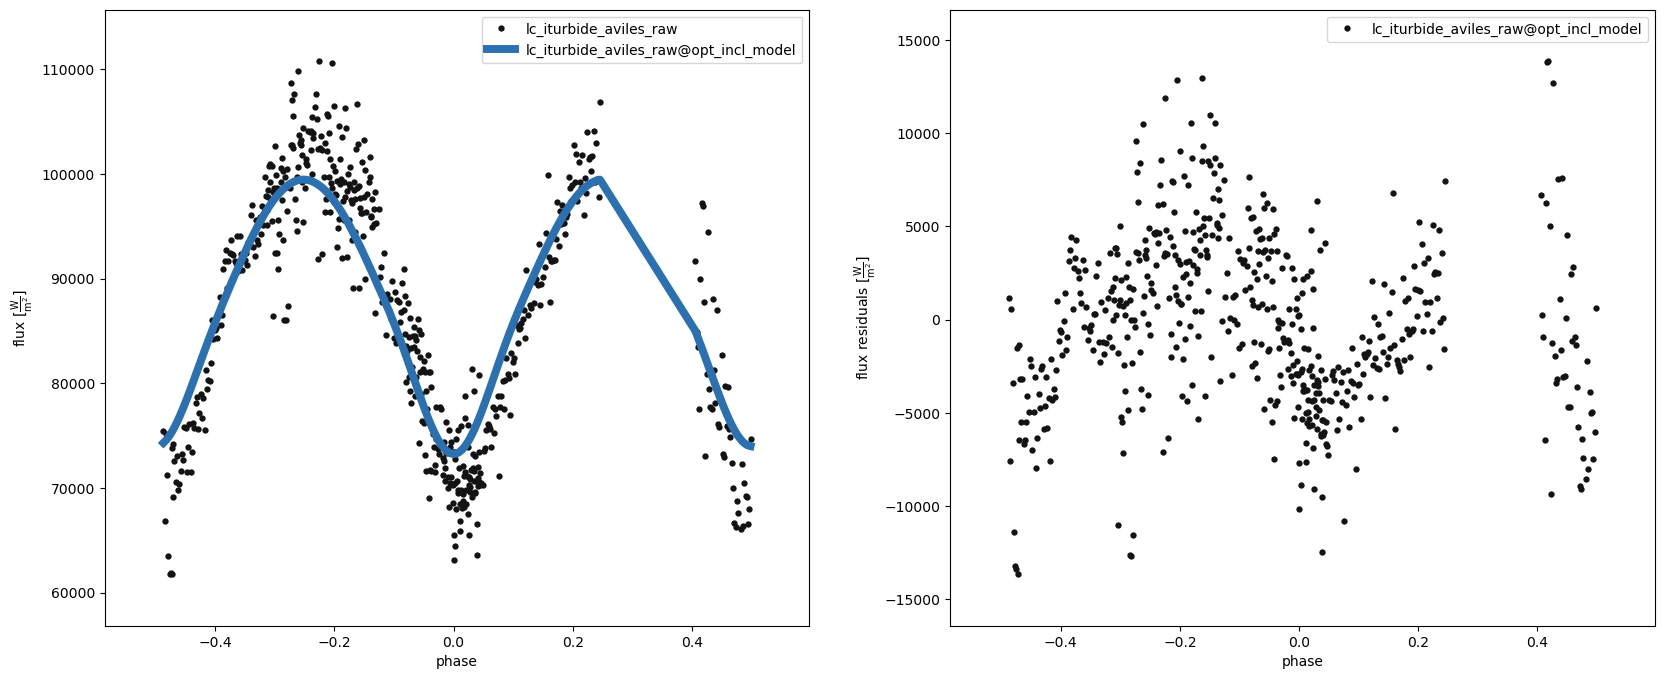

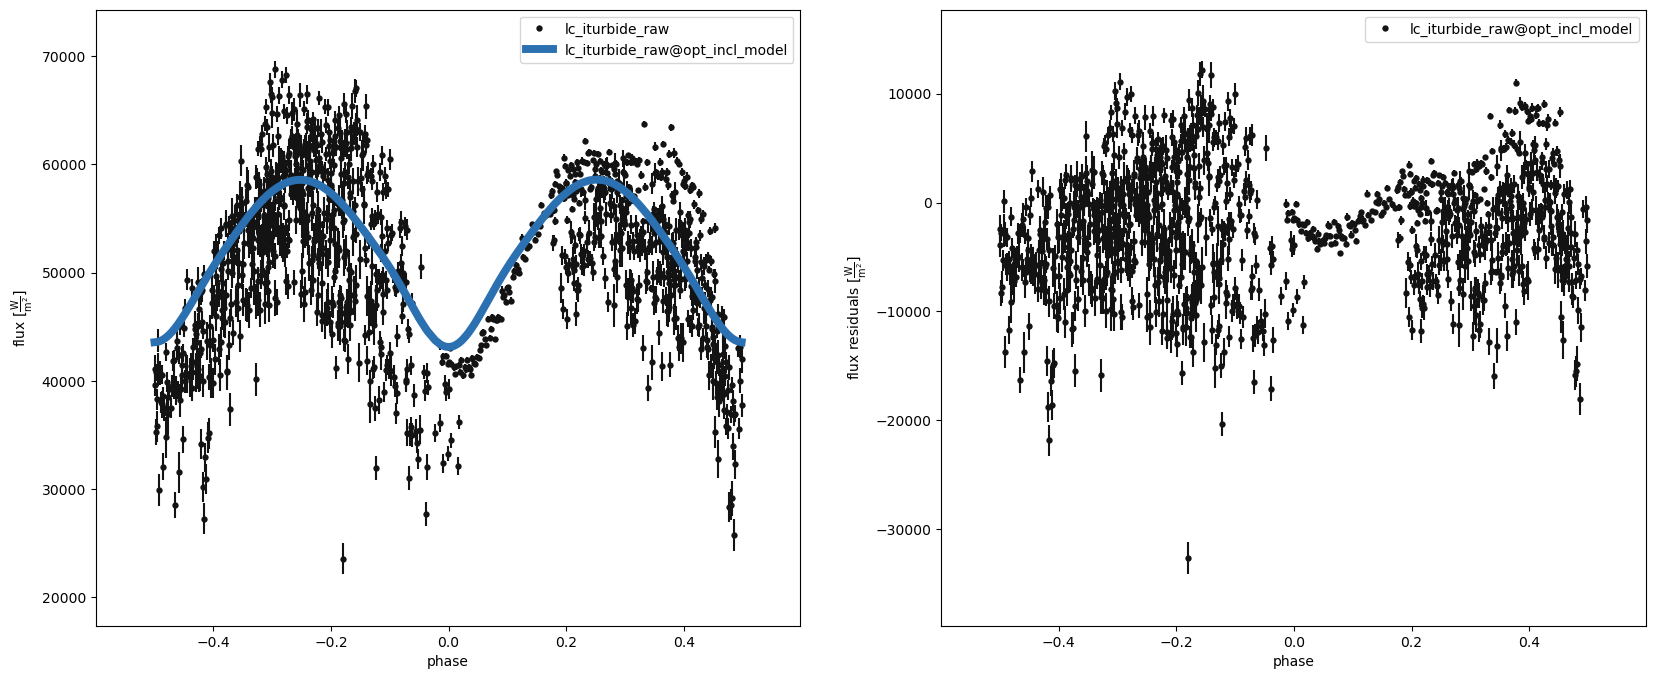

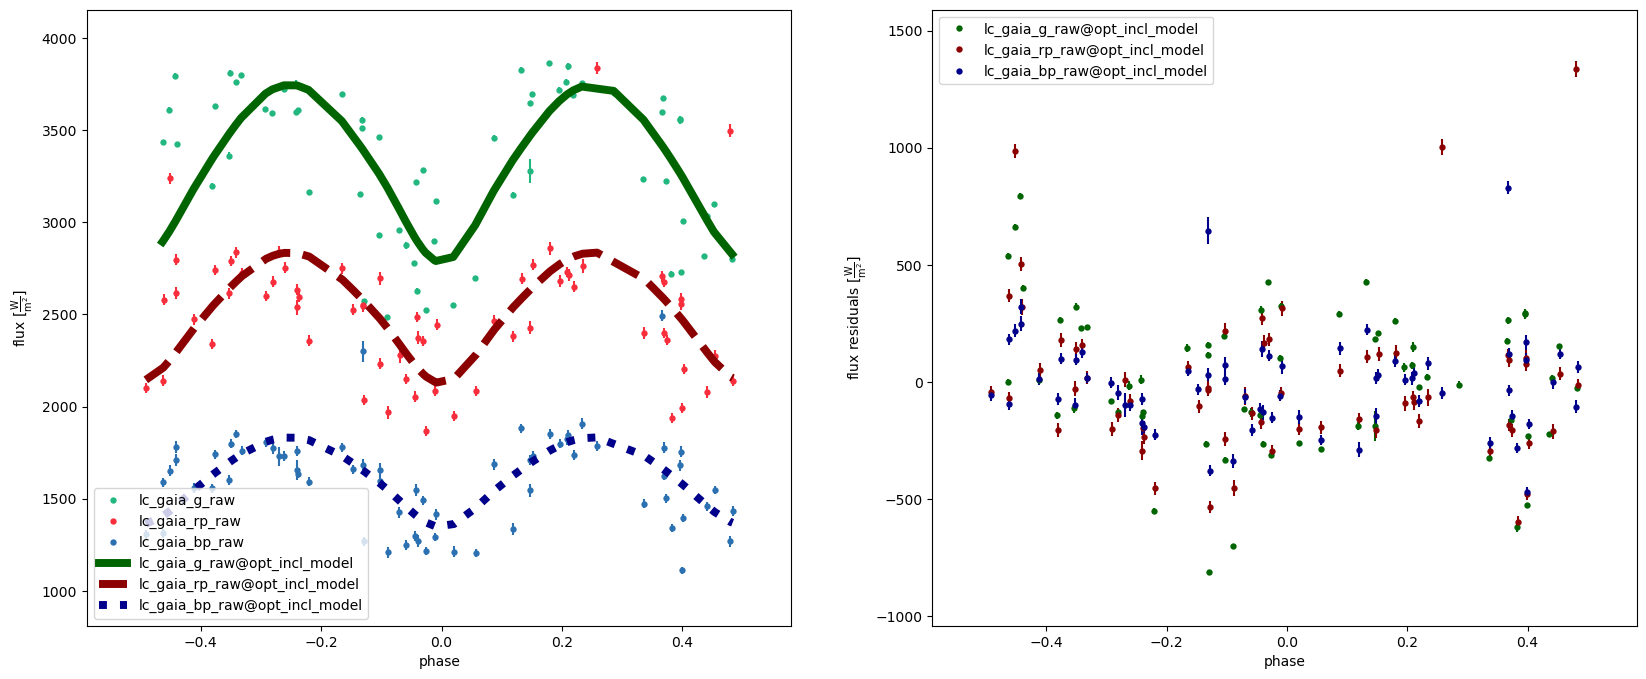

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

before_optimizers
-------------------------------------
	 Iturbide - 80372.91989078322
	 Gaia - 80636.76379268152
		 lc_gaia_g_raw - 68451.76819246518
		 lc_gaia_rp_raw - 8305.406739604648
		 lc_gaia_bp_raw - 3879.588860611689
aviles_unoptimized
-------------------------------------
opt_period_t0_model
-------------------------------------
	 Iturbide - 53773.14228630389
	 Gaia - 71524.04128715808
		 lc_gaia_g_raw - 60733.57522804268
		 lc_gaia_rp_raw - 7376.675925754388
		 lc_gaia_bp_raw - 3413.7901333610075
opt_q_massprim_noprior_model
-------------------------------------
	 Iturbide - 54432.95917682143
	 Gaia - 69296.9049461904
		 lc_gaia_g_raw - 58837.100187476426
		 lc_gaia_rp_raw - 7089.23179363449
		 lc_gaia_bp_raw - 3370.572965079494
opt_teffratio_ff_q_massprim_model
-------------------------------------
	 Iturbide - 53761.713602947864
	 Gaia - 70373.7303237192
		 lc_gaia_g_raw - 59826.04569797256
		 lc_gaia_rp_raw - 7179.9697028207775
		 lc_gaia_bp_raw - 3367.7149229258644
befo

In [50]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors-invertq/results/opt_incl_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_aviles_raw'], ['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)

for m in b.models:
	printChi2(b, m)

Adopted:
incl@binary@orbit@component = 61.80711 deg
q@binary@orbit@component = 1.43114 

Original values:
  incl@binary@orbit@component 63.18960180037622 deg
  q@binary@orbit@component 1.508919942860078


Thu, 26 Oct 2023 11:55 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Thu, 26 Oct 2023 11:55 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
100%|██████████| 1964/1964 [04:07<00:00,  7.95it/s]
Thu, 26 Oct 2023 11:59 BUNDL

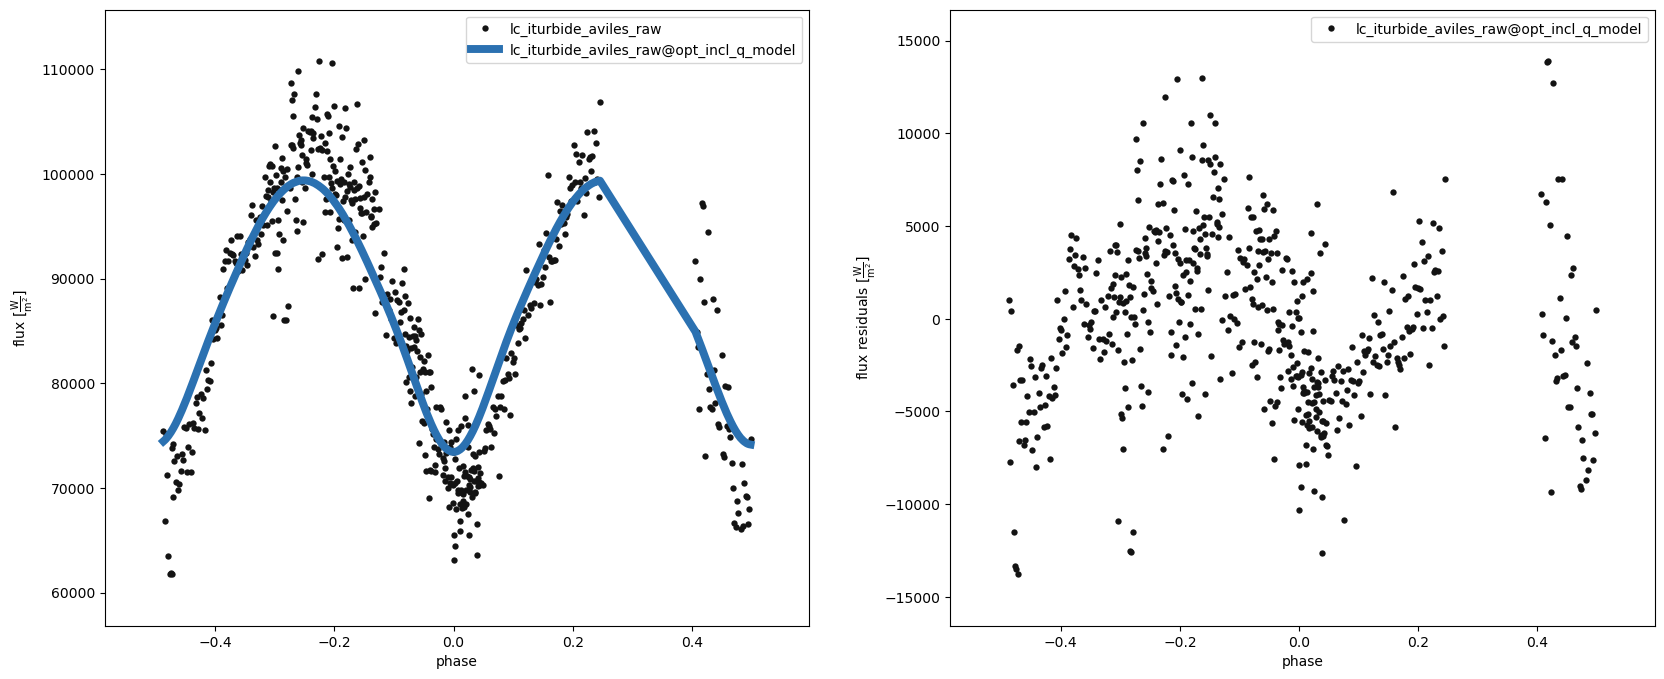

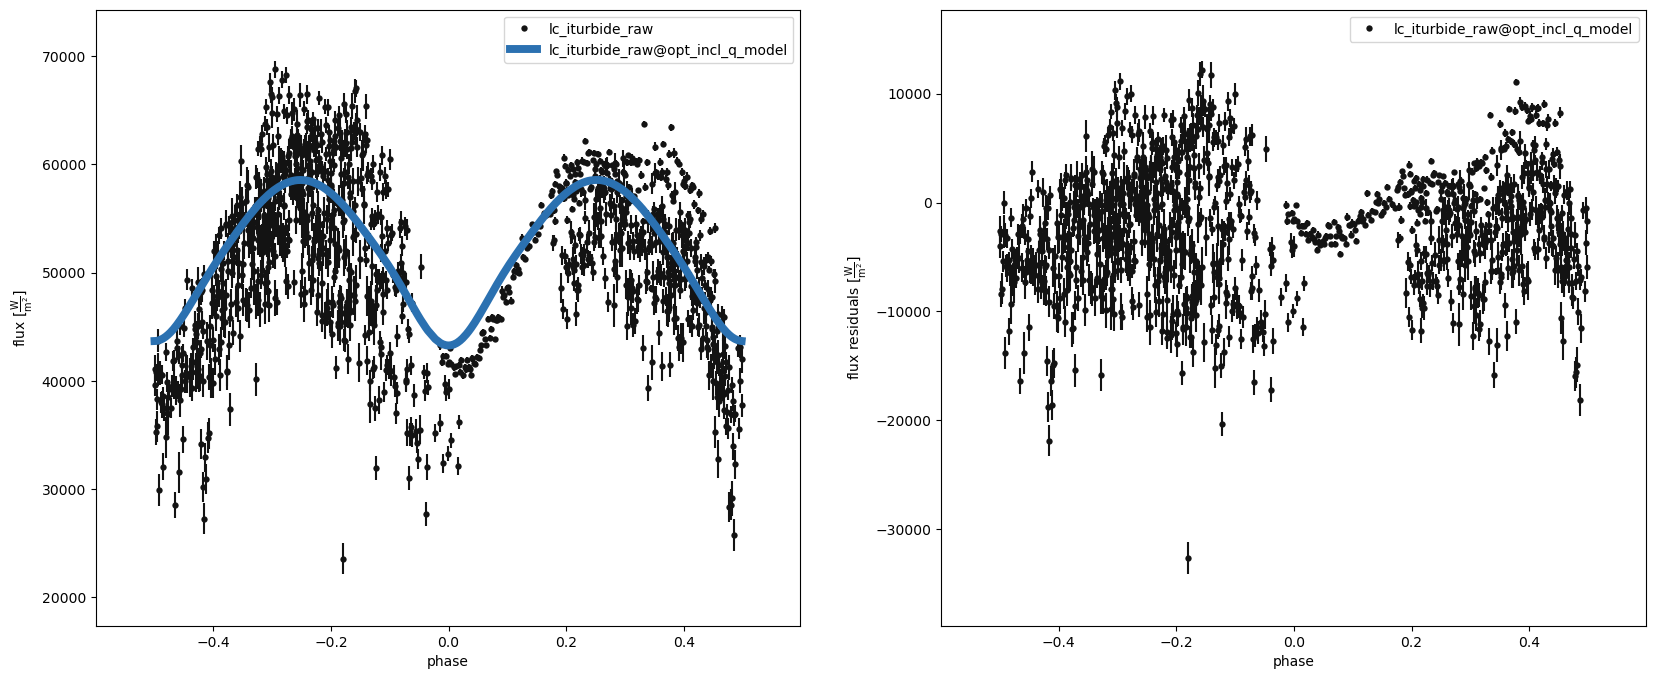

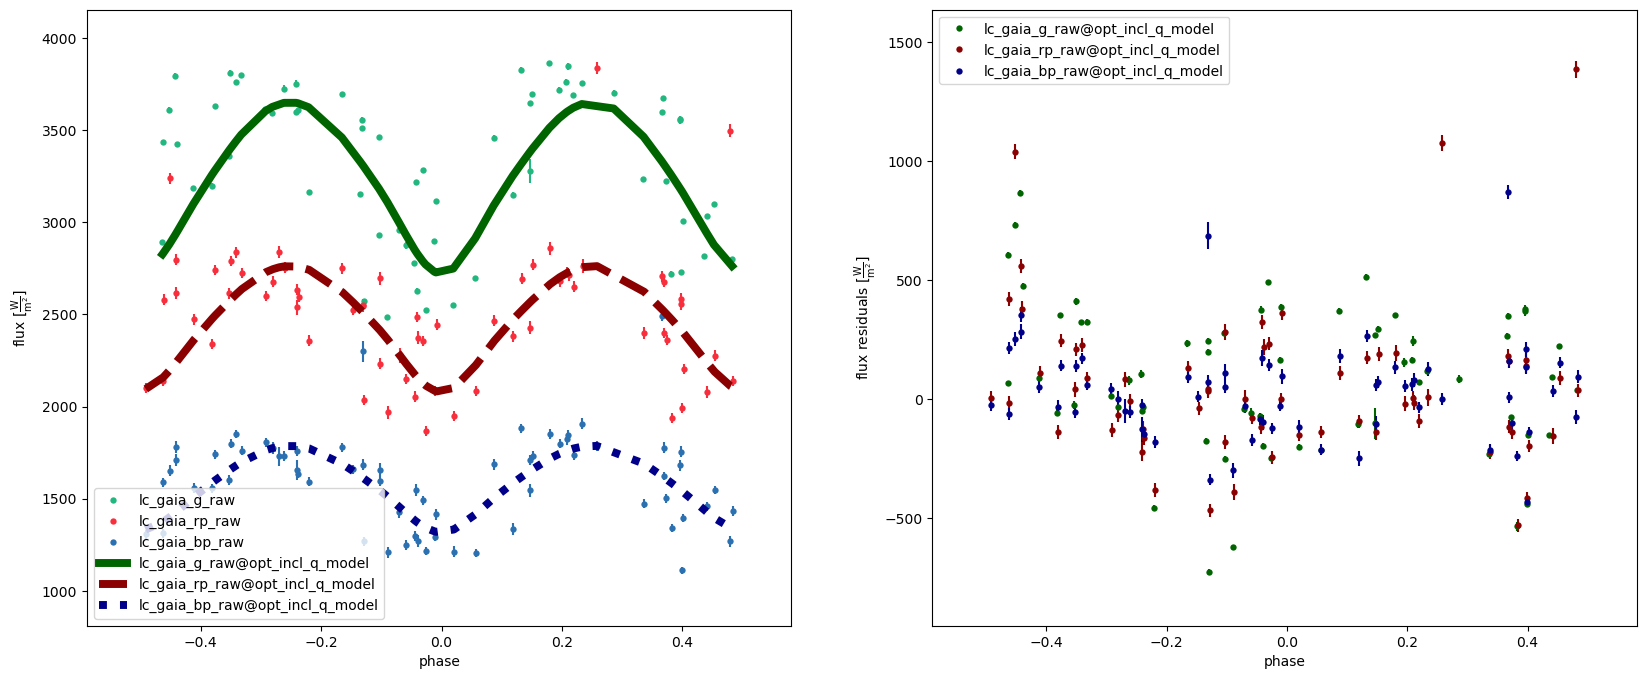

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

before_optimizers
-------------------------------------
	 Iturbide - 80372.91989078322
	 Gaia - 80636.76379268152
		 lc_gaia_g_raw - 68451.76819246518
		 lc_gaia_rp_raw - 8305.406739604648
		 lc_gaia_bp_raw - 3879.588860611689
aviles_unoptimized
-------------------------------------
opt_period_t0_model
-------------------------------------
	 Iturbide - 53773.14228630389
	 Gaia - 71524.04128715808
		 lc_gaia_g_raw - 60733.57522804268
		 lc_gaia_rp_raw - 7376.675925754388
		 lc_gaia_bp_raw - 3413.7901333610075
opt_q_massprim_noprior_model
-------------------------------------
	 Iturbide - 54432.95917682143
	 Gaia - 69296.9049461904
		 lc_gaia_g_raw - 58837.100187476426
		 lc_gaia_rp_raw - 7089.23179363449
		 lc_gaia_bp_raw - 3370.572965079494
opt_teffratio_ff_q_massprim_model
-------------------------------------
	 Iturbide - 53761.713602947864
	 Gaia - 70373.7303237192
		 lc_gaia_g_raw - 59826.04569797256
		 lc_gaia_rp_raw - 7179.9697028207775
		 lc_gaia_bp_raw - 3367.7149229258644
befo

In [51]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors-invertq/results/opt_incl_q_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_aviles_raw'], ['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)

for m in b.models:
	printChi2(b, m)

## Including `teff@primary` to allow primary temperature to keep changing

* **Skipping for now**; since we still need to calculate the passband luminosity (which will involve changing `teff@primary` and `teffratio`) this won't be 
optimized for at this time

In [3]:
# b = phoebe.load("./bundle-saves/full-diff-data/dataset-scaled-optimized")
b = phoebe.load("./bundle-saves/poro-invertq/dataset-scaled-optimized")

In [34]:
backupBundle = b.copy()

In [20]:
print(b['teff@primary'])
print(b['teffratio'])

Parameter: teff@primary@component
                       Qualifier: teff
                     Description: Mean effective temperature
                           Value: 6000.0 K
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teffratio@binary@component, teff@secondary@component

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.8800597213958596
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component



In [36]:
print(b['poro_porb_bounds'])

ParameterSet: 2 parameters
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.3952841304745 high=5826.418016107988 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0683770832767032 high=1.1764144867486253 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>


In [21]:
# opt_utils.optimize_params(b, fit_twigs=['teff@primary', 'teffratio', 'fillout_factor'], label='tp_tr_ff', export=True, 
# 						  subfolder='differential-norm-estimates', datasets=allRawDatasets, 
# 						  maxiter=250)
opt_utils.optimize_params(b, fit_twigs=['teff@primary', 'teffratio', 'fillout_factor'], label='tp_tr_ff', export=True, 
						  subfolder='poro-priors-invertq', datasets=allRawDatasets, 
						  maxiter=250)

Fri, 22 Sep 2023 13:56 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.


External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_tp_tr_ff.py ./results/opt_tp_tr_ff_solution


('opt_tp_tr_ff', 'opt_tp_tr_ff_solution')

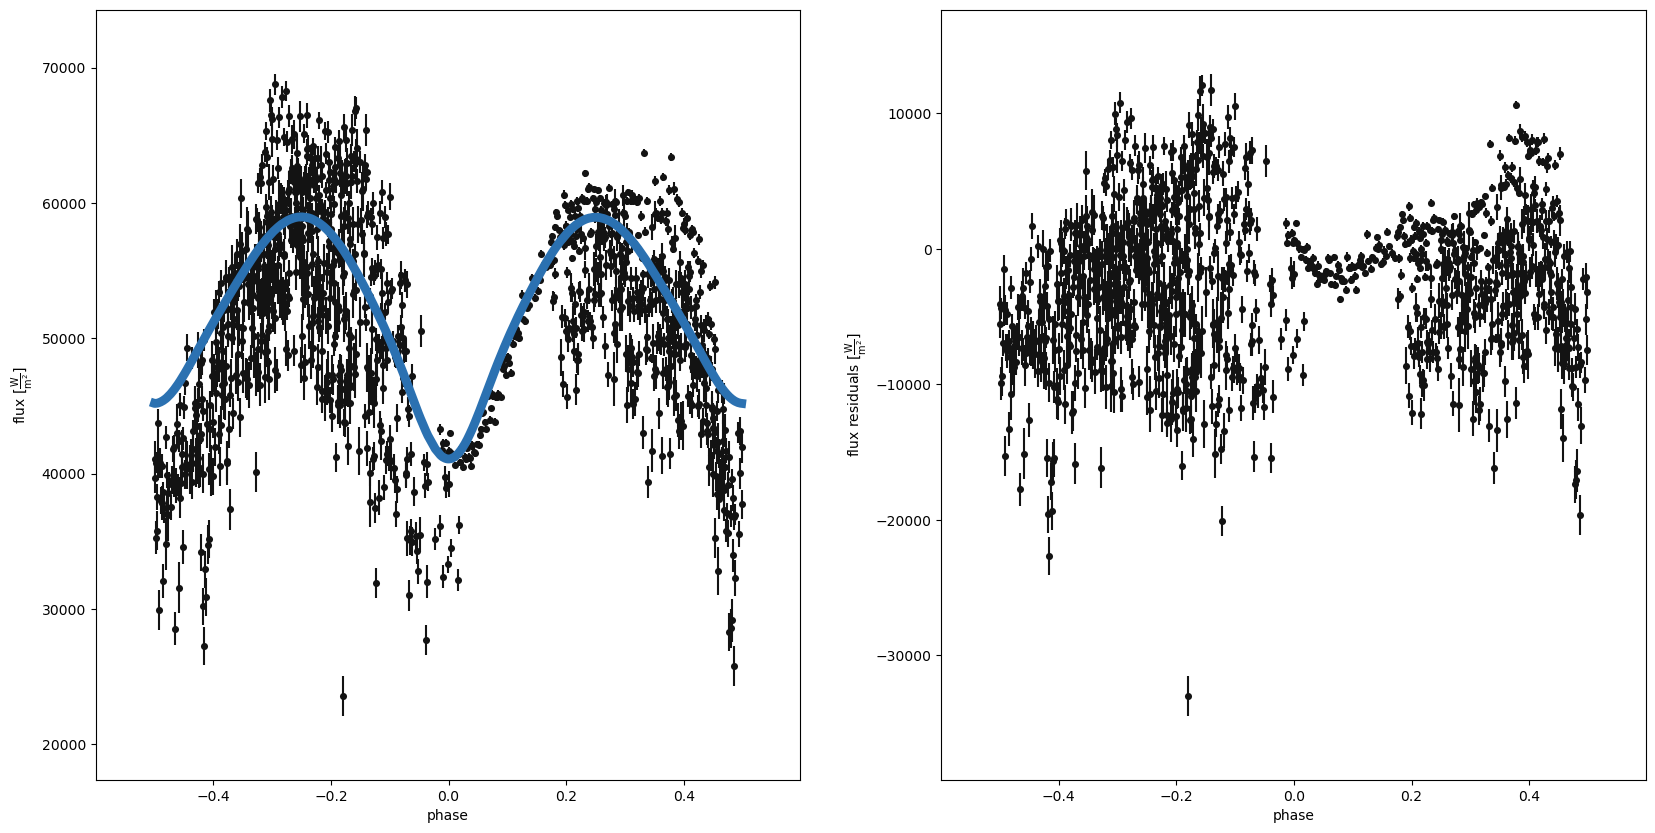

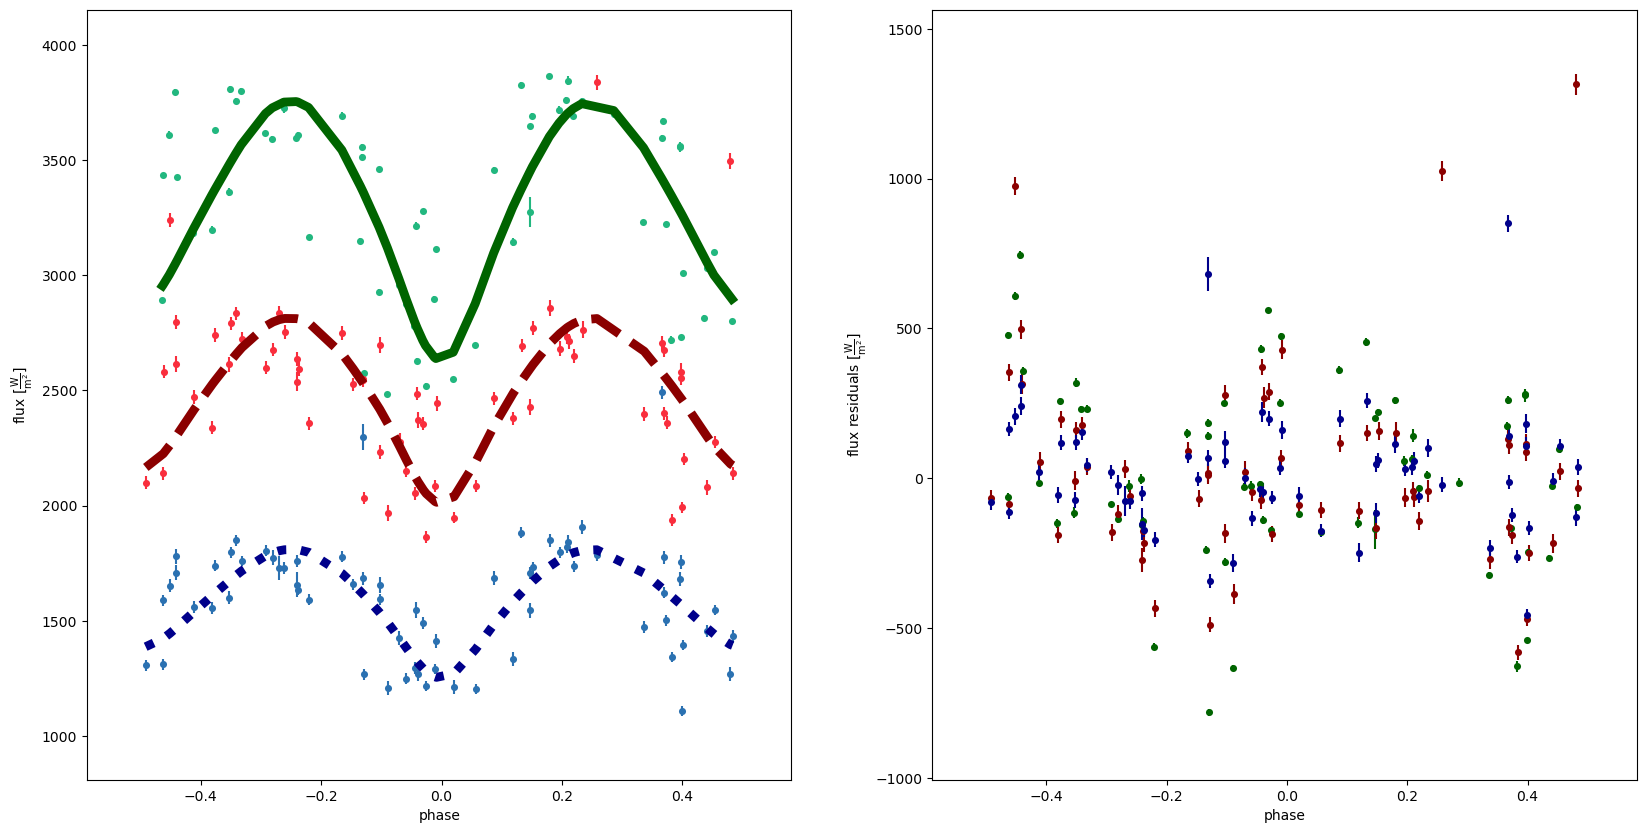

opt_tp_tr_ff_model
-------------------------------------
	 Iturbide - 54061.41408453537
	 Gaia - 69658.09026204859
		 lc_gaia_g_raw - 59188.90906520911
		 lc_gaia_rp_raw - 7114.535337049358
		 lc_gaia_bp_raw - 3354.6458597901174


In [34]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_tp_tr_ff_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, figsize=(20,10), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, color=gen_utils.GAIA_RAW_PLOT_COLORS)
printChi2(b, computeModelName)

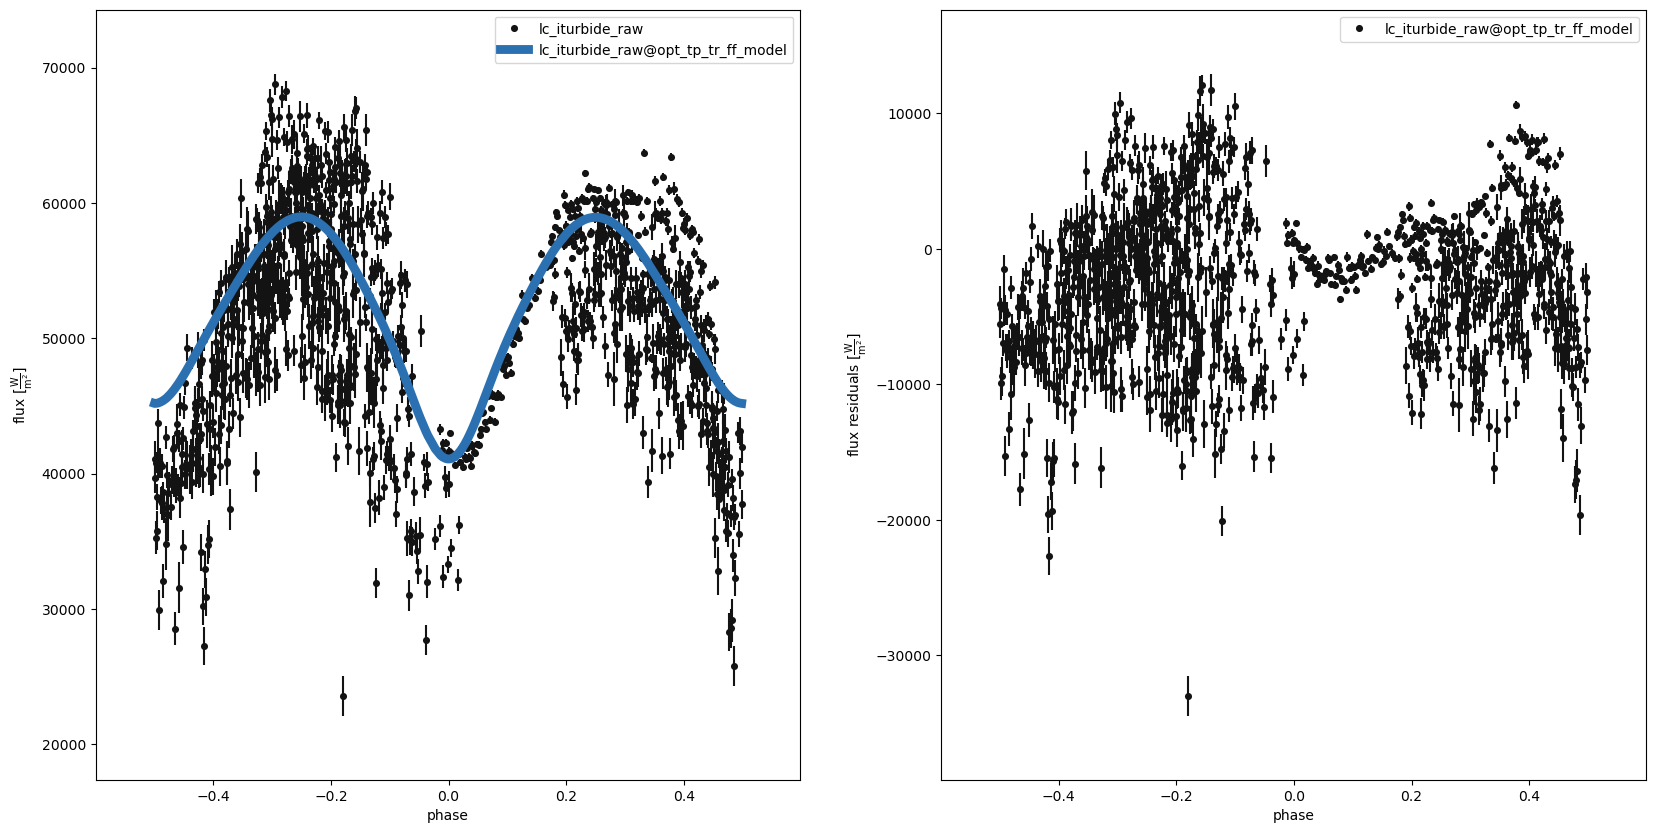

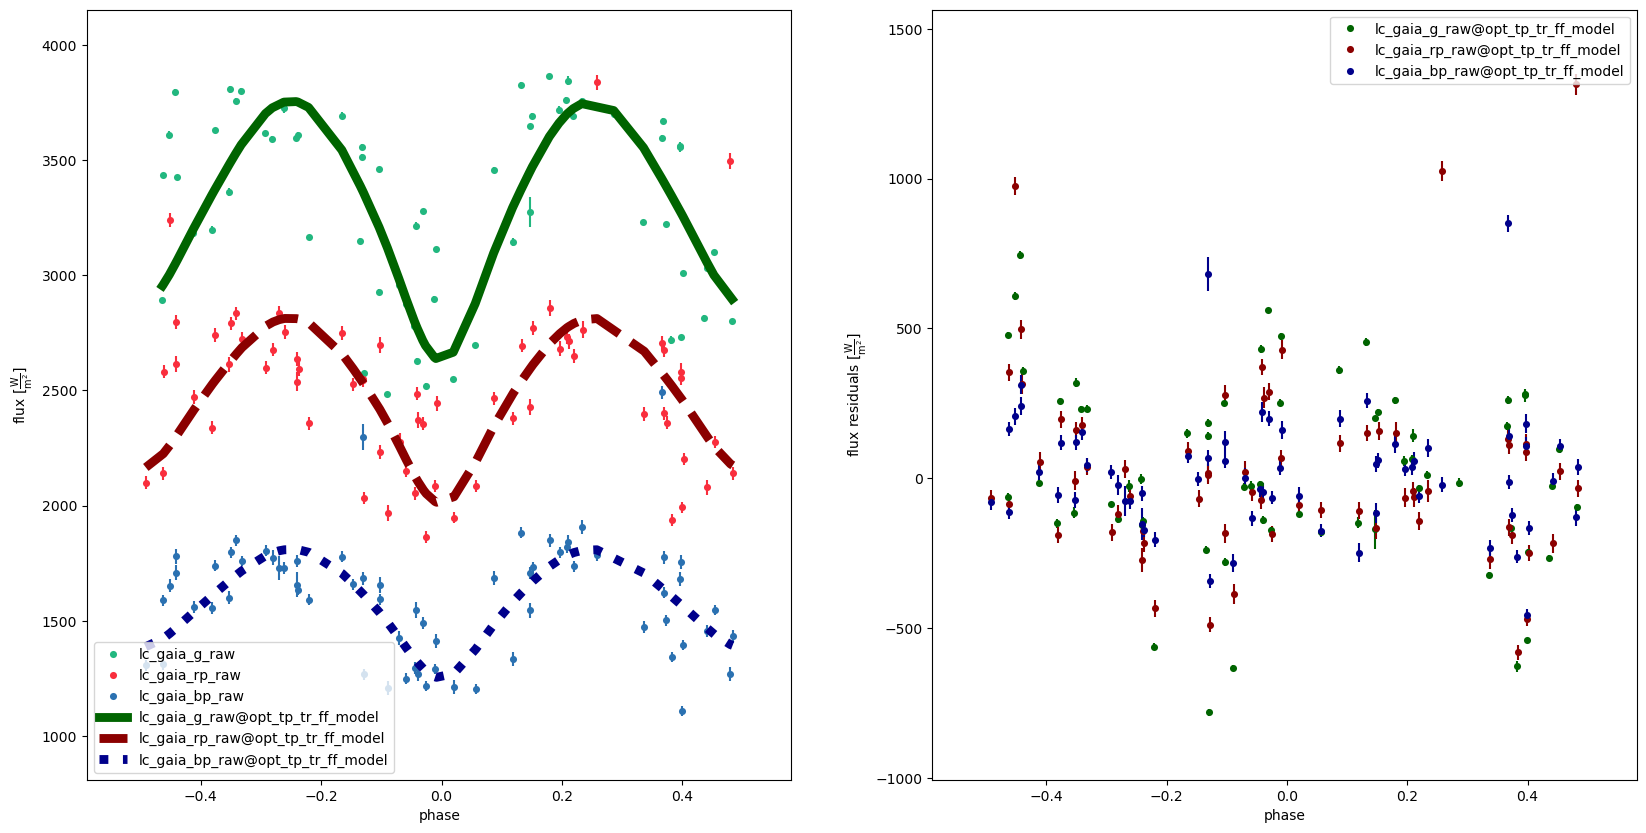

In [11]:
gen_utils.plotModelResidualsFigsize(b, figsize=(20,10), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model='opt_tp_tr_ff_model', color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)

In [46]:
gen_utils.animateMesh(b, logger)

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [37]:
for m in b.models:
	printChi2(b, m)
	print()

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974

opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013

opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532

opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 52991.952262979496
	 Gaia - 72771.86102981483
		 lc_gaia_g_raw - 62131.844317668496
		 lc_gaia_rp_raw - 7246.9434312625235
		 lc_gaia_bp_raw - 3393.073280883809

opt_teffratio_ff_rawdata_model
------------------------

## Checkpoint

In [55]:
gen_utils.saveBundle(b, "dataset-scaled-optimized", subfolder="full-diff-data")

'bundle-saves/full-diff-data/dataset-scaled-optimized'

## Adjusting the passband luminosity

Will be trying to adjust the passband luminosity for both the Iturbide light curve as well as the Gaia G light curve. To preserve the colors,
Gaia BP and RP will be set to scale to Gaia G (if possible).

In [3]:
# b = phoebe.load("./bundle-saves/full-diff-data/dataset-scaled-optimized")
b = phoebe.load("./bundle-saves/poro-invertq/dataset-scaled-optimized")

In [32]:
pb_backup = b.copy()

In [33]:
print(b['teff'])

ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 5407.756209007656 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.3952841304745 high=5826.418016107988 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>


In [ ]:
%%script echo "skip unless need to restore backup"
b = pb_backup.copy()

In [36]:
b.set_value(qualifier='pblum_mode', dataset='lc_iturbide_raw', value='component-coupled')
b.set_value(qualifier='pblum_mode', dataset='lc_iturbide_aviles_raw', value='component-coupled')
b.set_value(qualifier='pblum_mode', dataset='lc_gaia_g_raw', value='component-coupled')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_rp_raw', value='dataset-coupled')
b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_raw', value='dataset-coupled')

# coupling gaia datasets together
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_rp_raw', value='lc_gaia_g_raw')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_raw', value='lc_gaia_g_raw')

100%|██████████| 1964/1964 [03:11<00:00, 10.27it/s]
Wed, 25 Oct 2023 16:52 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


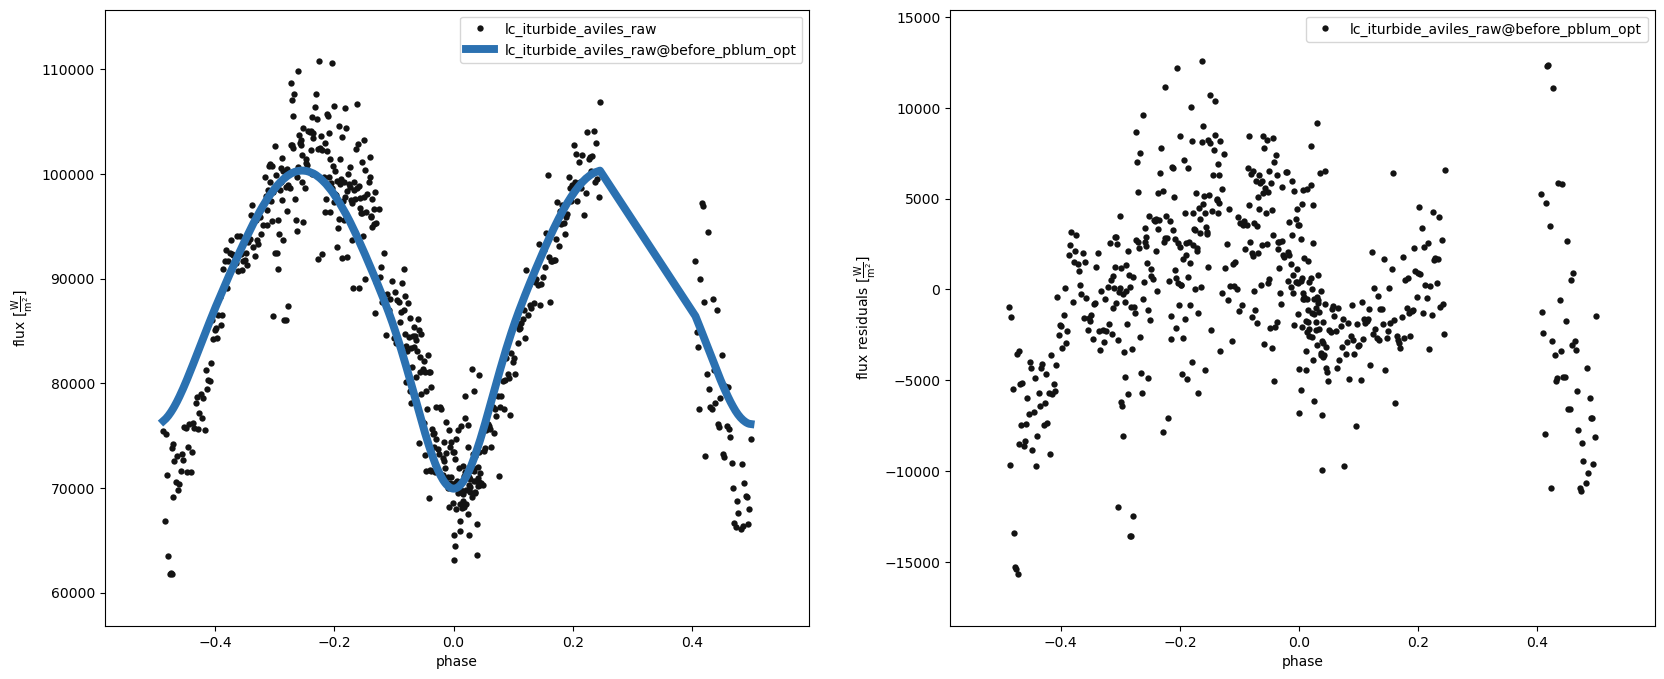

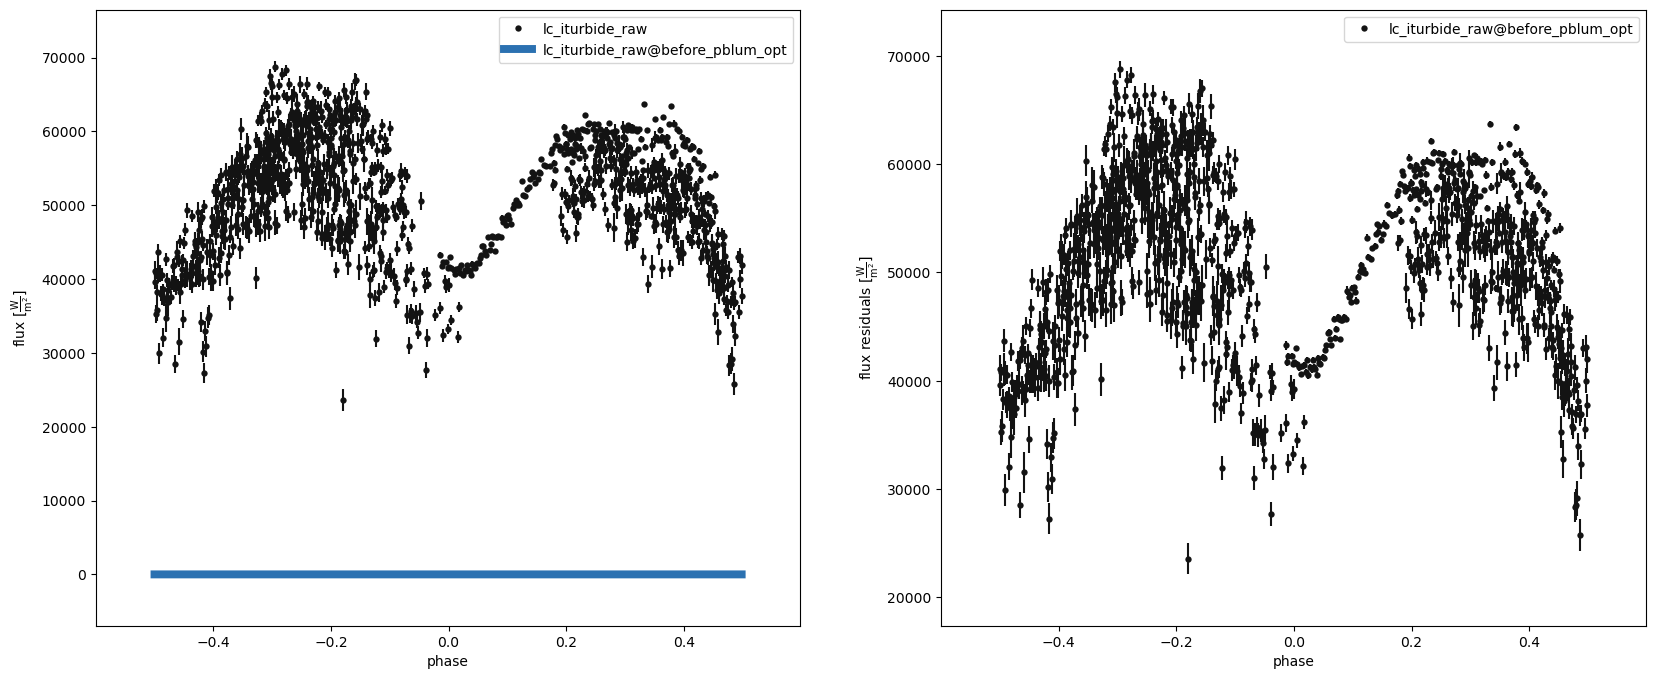

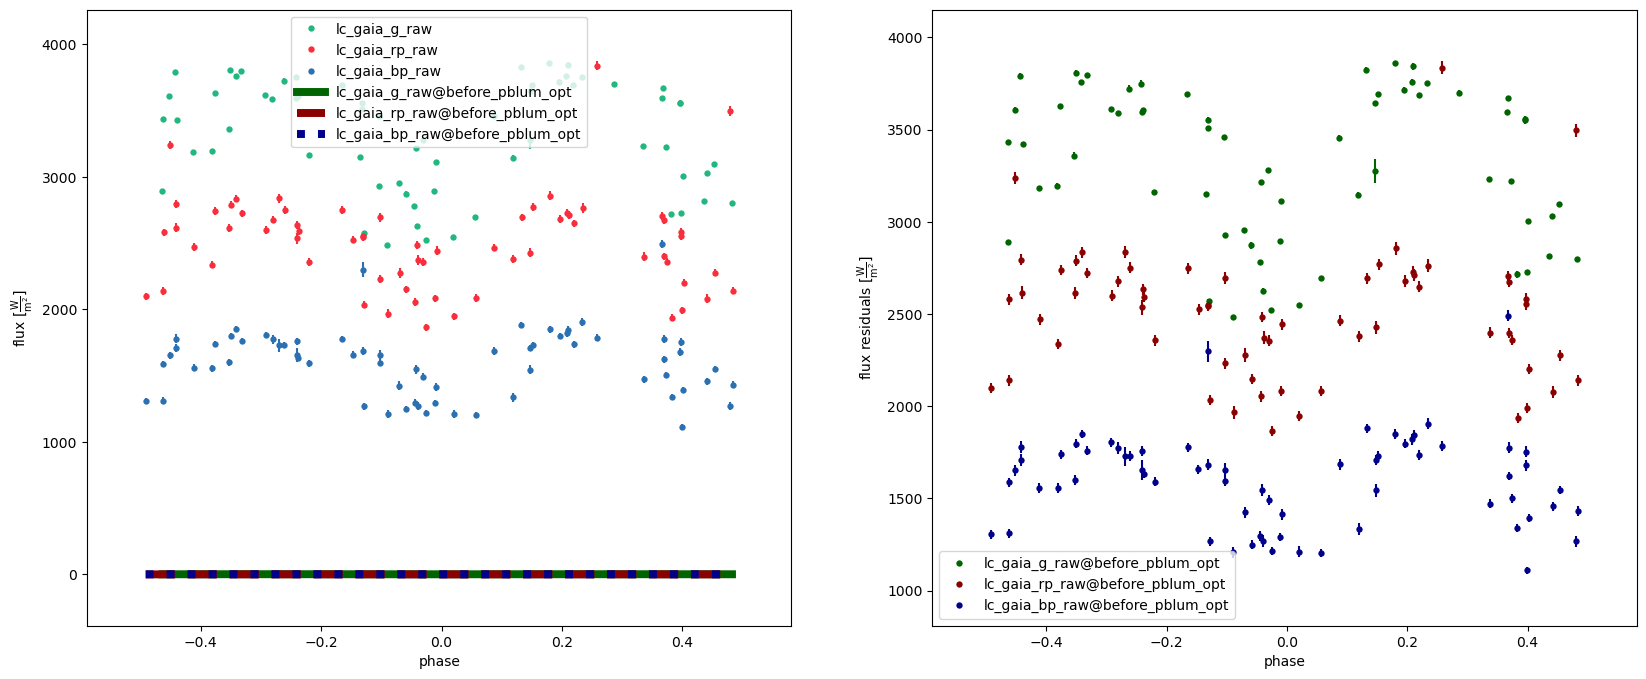

In [35]:
# TODO re-run now that aviles dataset is component-coupled instead of dataset-scaled
b.run_compute(model='before_pblum_opt', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=[['lc_iturbide_aviles_raw'], ['lc_iturbide_raw'], rawGaiaDatasets], model='before_pblum_opt', color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [40]:
print(b['pblum']) # equal to 4*pi

ParameterSet: 2 parameters
   pblum@primary@lc_iturbide_r...: 12.566370614359172 W
   pblum@primary@lc_gaia_g_raw...: 12.566370614359172 W


### Initial correcting of Gaia passband luminosity, without changing the system temperatures **(skipping for now to see if it can be corrected for at the same time)**

In [8]:
# opt_utils.optimize_params(b, label='pblum_gaia', export=True, subfolder='differential-norm-estimates', 
# 						  fit_twigs=['pblum@lc_gaia_g_raw@primary'], datasets=rawGaiaDatasets)

opt_utils.optimize_params(b, label='pblum_gaia', export=True, subfolder='poro-priors-invertq', 
						  fit_twigs=['pblum@lc_gaia_g_raw@primary'], datasets=rawGaiaDatasets)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_pblum_iturbide.py ./results/opt_pblum_iturbide_solution
External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_pblum_gaia.py ./results/opt_pblum_gaia_solution


('opt_pblum_gaia', 'opt_pblum_gaia_solution')

In [12]:
opt_utils.adopt_solution(b, reset_params=True, solution_file="./external-jobs/differential-norm-estimates/results/opt_pblum_gaia_solution", plot=False)

Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset = 29034.10559 W

Original values:
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


100%|██████████| 1414/1414 [04:05<00:00,  5.76it/s]


AdoptSolutionResult(solutionName='opt_pblum_gaia_solution', computeModelName='opt_pblum_gaia_model')

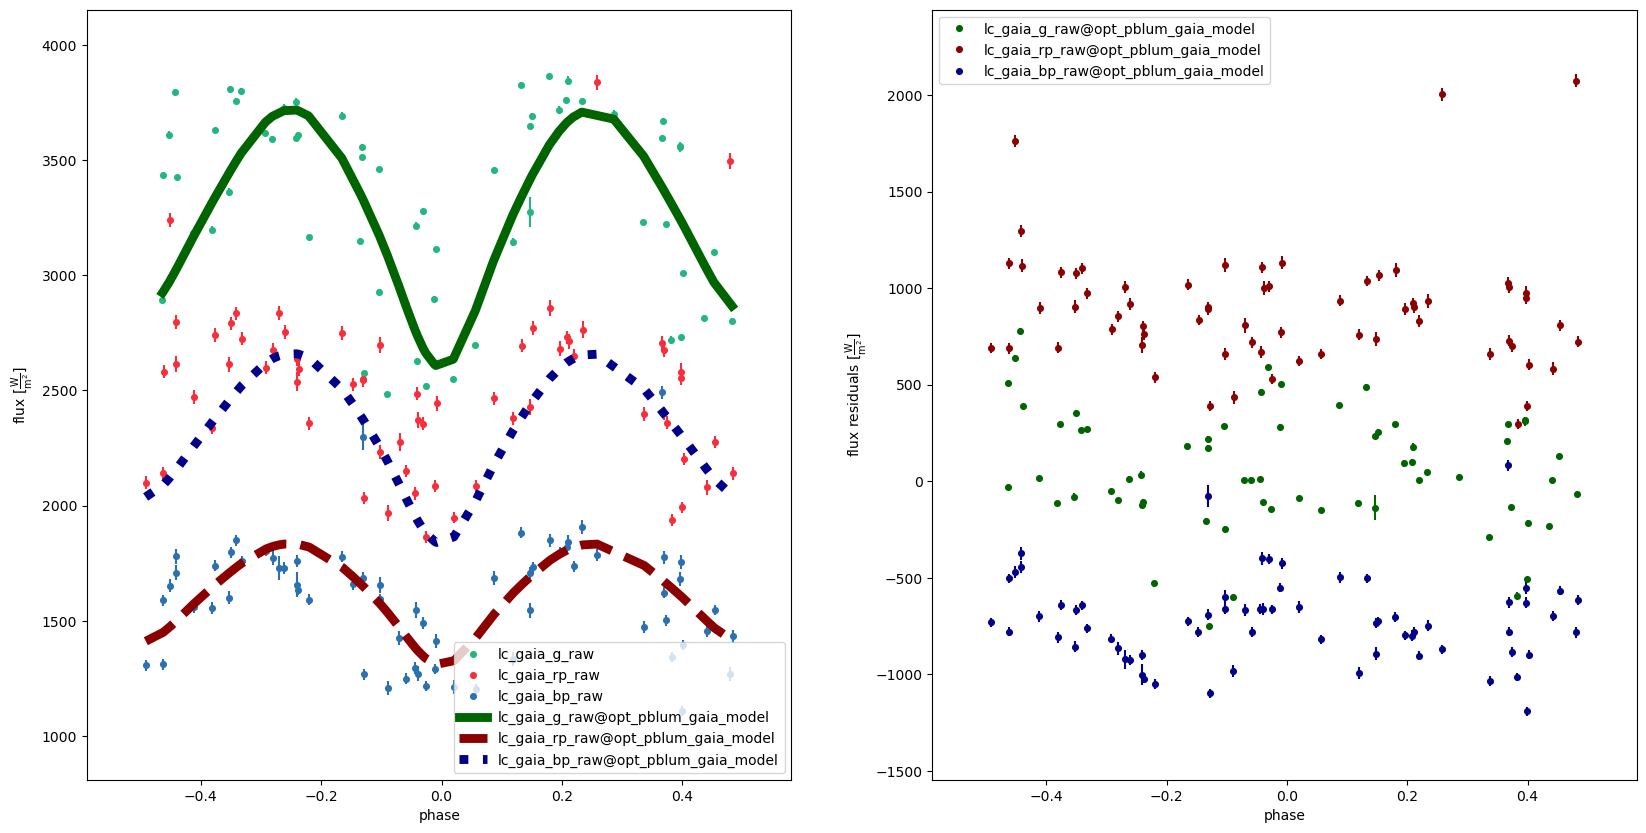

In [13]:
gen_utils.plotModelResidualsFigsize(b, (20,10), [rawGaiaDatasets], 'opt_pblum_gaia_model', legend=True, color=gen_utils.GAIA_RAW_PLOT_COLORS)

### Correcting `teffratio` with new passband luminosities from Gaia

Gaia colors look to be inverted, thinking it's a problem with the component temperatures

In [37]:
print(b['teffratio'])
print(b['teff@primary'])
print(b['pblum@lc_gaia_g_raw'])

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.9012927015012759
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

ParameterSet: 2 parameters
           teff@primary@component: 6000.0 K
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.3952841304745 high=5826.418016107988 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
Parameter: pblum@primary@lc_gaia_g_raw@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.566370614359172 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only vi

In [47]:
# trying also optimizing pblum at the same time, to compensate for the changing intrinsic luminosity

# opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@lc_gaia_g_raw@primary'], label='tr_tprim_pbgaiag', export=True,
# 						  subfolder='differential-norm-estimates', datasets=rawGaiaDatasets, maxiter=500)

teffPrimaryDist = b.get_value(qualifier='teff', component='primary', context='distribution')
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@lc_gaia_g_raw@primary'], label='tr_tprim_pbgaiag', export=True,
						  subfolder='poro-priors-invertq', datasets=rawGaiaDatasets, maxiter=1000, initial_values={'teff@primary': teffPrimaryDist.sample()})

External Solver: ./external-jobs/poro-priors-invertq/optimizer.nelder_mead_opt_tr_tprim_pbgaiag.py ./results/opt_tr_tprim_pbgaiag_solution


('opt_tr_tprim_pbgaiag', 'opt_tr_tprim_pbgaiag_solution')

In [54]:
# trying optimizing without teff@primary; otherwise, the optimizers seem to take the temperature
# out of the desired range
teffPrimaryDist = b.get_value(qualifier='teff', component='primary', context='distribution')
b.set_value(qualifier='teff', component='primary', context='component', value=teffPrimaryDist.sample()) # setting directly, exported optimizer doesn't work otherwise
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'pblum@lc_gaia_g_raw@primary'], label='tr_pbgaiag', export=True,
						  subfolder='poro-priors-invertq', datasets=rawGaiaDatasets, maxiter=1000)

External Solver: ./external-jobs/poro-priors-invertq/optimizer.nelder_mead_opt_tr_pbgaiag.py ./results/opt_tr_pbgaiag_solution


('opt_tr_pbgaiag', 'opt_tr_pbgaiag_solution')

Adopted:
teffratio@binary@orbit@component = 0.98448 
teff@primary@star@component = 4006.55445 K
pblum@primary@lc_gaia_g_raw@lc@dataset = 18391.84131 W

Original values:
  teffratio@binary@orbit@component 0.9012927015012759
  teff@primary@star@component 6000.0 K
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


100%|██████████| 213/213 [00:23<00:00,  9.11it/s]


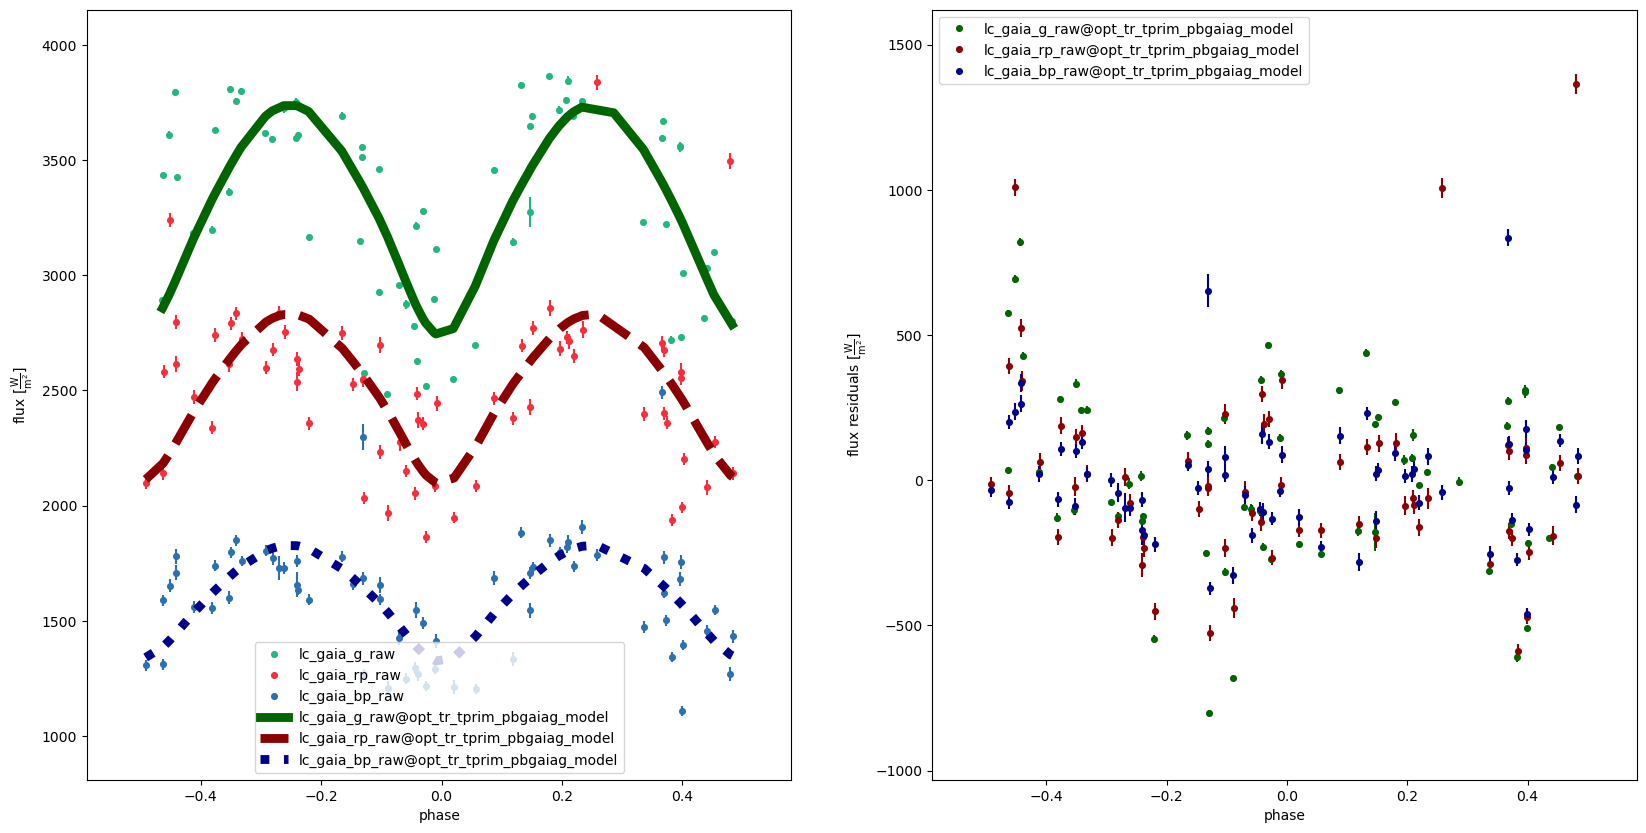

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [38]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/differential-norm-estimates/results/opt_tr_tprim_pbgaiag_solution', plot=False, reset_params=True)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/poro-priors-invertq/results/opt_tr_tprim_pbgaiag_solution', plot=False, reset_params=False)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=[rawGaiaDatasets], model=computeModelName, color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)
gen_utils.abilitateDatasets(b, b.datasets)

In [53]:
prevIncl = b.get_value(qualifier='incl', component='binary')
print(b['incl'])
prevIncl

Parameter: incl@binary@component
                       Qualifier: incl
                     Description: Orbital inclination angle
                           Value: 63.18960180037622 deg
                  Constrained by: 
                      Constrains: asini@binary@component, asini@primary@component, incl@primary@component, asini@secondary@component, incl@secondary@component
                      Related to: sma@binary@component, asini@binary@component, q@binary@component, asini@primary@component, pitch@primary@component, incl@primary@component, asini@secondary@component, pitch@secondary@component, incl@secondary@component



63.18960180037622

In [54]:
b.set_value(qualifier='incl', component='binary', value=72*u.deg)

100%|██████████| 1751/1751 [03:07<00:00,  9.35it/s]
Thu, 26 Oct 2023 17:34 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


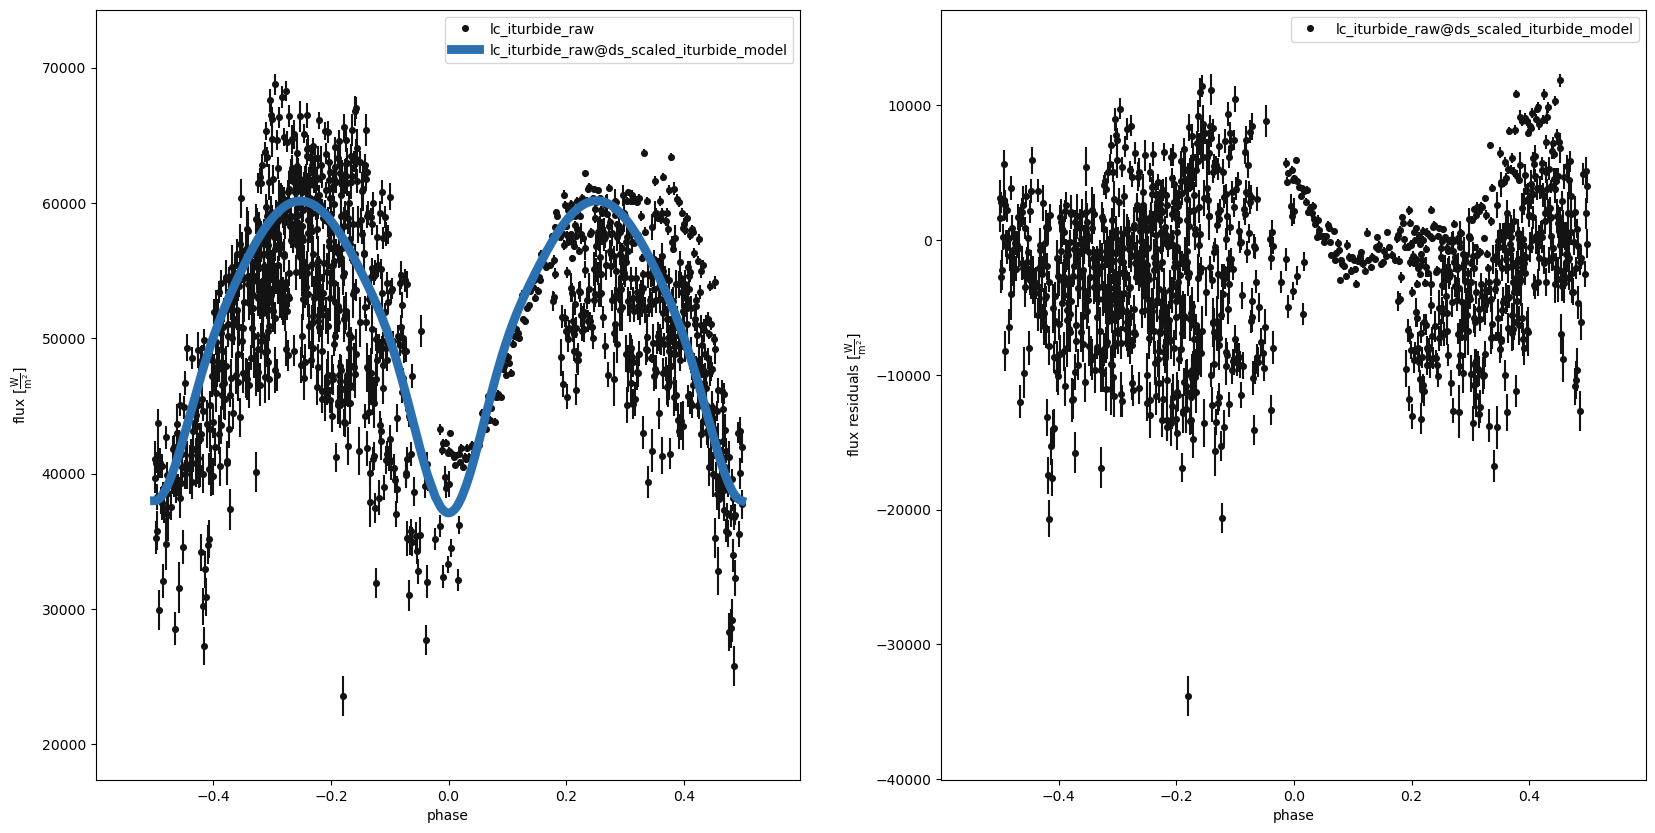

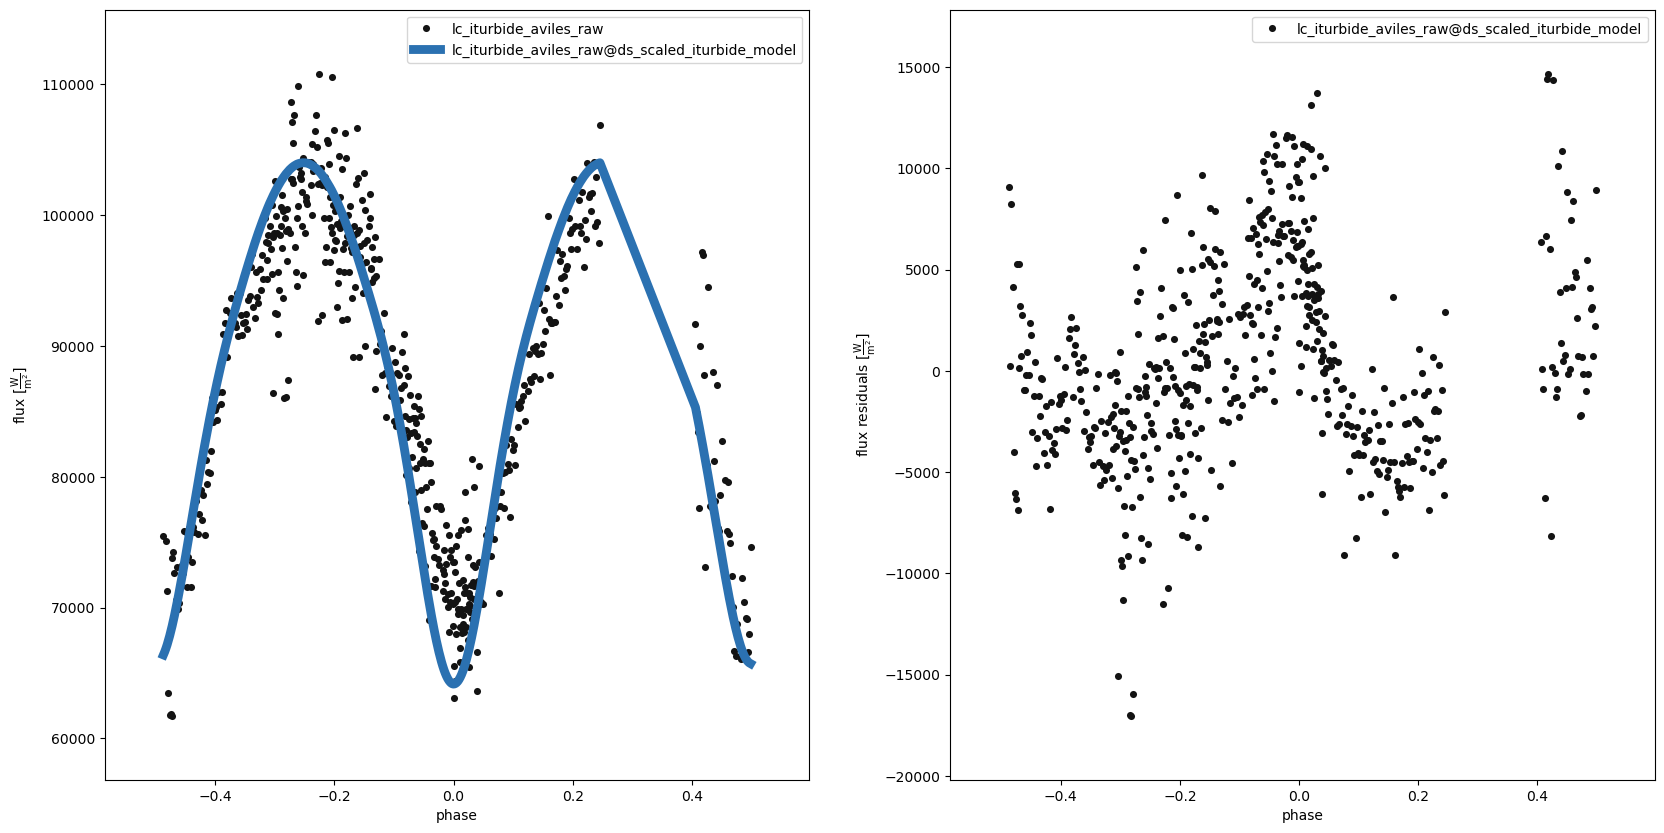

In [56]:
b.set_value_all(qualifier='pblum_mode', dataset=['lc_iturbide_raw', 'lc_iturbide_aviles_raw'], value="dataset-scaled")
gen_utils.abilitateDatasets(b, ['lc_iturbide_raw', 'lc_iturbide_aviles_raw'], False)
b.run_compute(model="ds_scaled_iturbide_model", overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=[['lc_iturbide_raw'], ['lc_iturbide_aviles_raw']], model="ds_scaled_iturbide_model", color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)

In [44]:
print(b['incl'])
print(b['q'])
print(b['mass'])
print(b['sma'])
print(b['requiv'])
print(b['requivratio'])
print(b['fillout_factor'])
print(b['teff'])

Parameter: incl@binary@component
                       Qualifier: incl
                     Description: Orbital inclination angle
                           Value: 63.18960180037622 deg
                  Constrained by: 
                      Constrains: asini@binary@component, asini@primary@component, incl@primary@component, asini@secondary@component, incl@secondary@component
                      Related to: sma@binary@component, asini@binary@component, q@binary@component, asini@primary@component, pitch@primary@component, incl@primary@component, asini@secondary@component, pitch@secondary@component, incl@secondary@component

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 1.508919942860078
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@co

In [57]:
print(b['opt_tr_pbgaiag_solution'])

ParameterSet: 11 parameters
R  fitted_twigs@opt_tr_pbgaiag...: ['teffratio@binary@orbit@component'
 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_parameters@opt_tr_pbg...: ['teffratio@binary@orbit@component', 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_distributions@opt_tr_...: False
   adopt_values@opt_tr_pbgaiag...: True
R  message@opt_tr_pbgaiag@opt_...: Optimization terminated successfully.
R  niter@opt_tr_pbgaiag@opt_tr...: 175
R  success@opt_tr_pbgaiag@opt_...: True
R  initial_values@opt_tr_pbgai...: [0.9012927015012759 12.566370614359172]
R  fitted_values@opt_tr_pbgaia...: [0.8279644471096448 27476.496439390656]
R  fitted_units@opt_tr_pbgaiag...: ['' 'W']
   comments@opt_tr_pbgaiag@opt...: 


Adopted:
teffratio@binary@orbit@component = 0.82796 
pblum@primary@lc_gaia_g_raw@lc@dataset = 27476.49644 W

Original values:
  teffratio@binary@orbit@component 0.9012927015012759
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


100%|██████████| 213/213 [00:22<00:00,  9.30it/s]


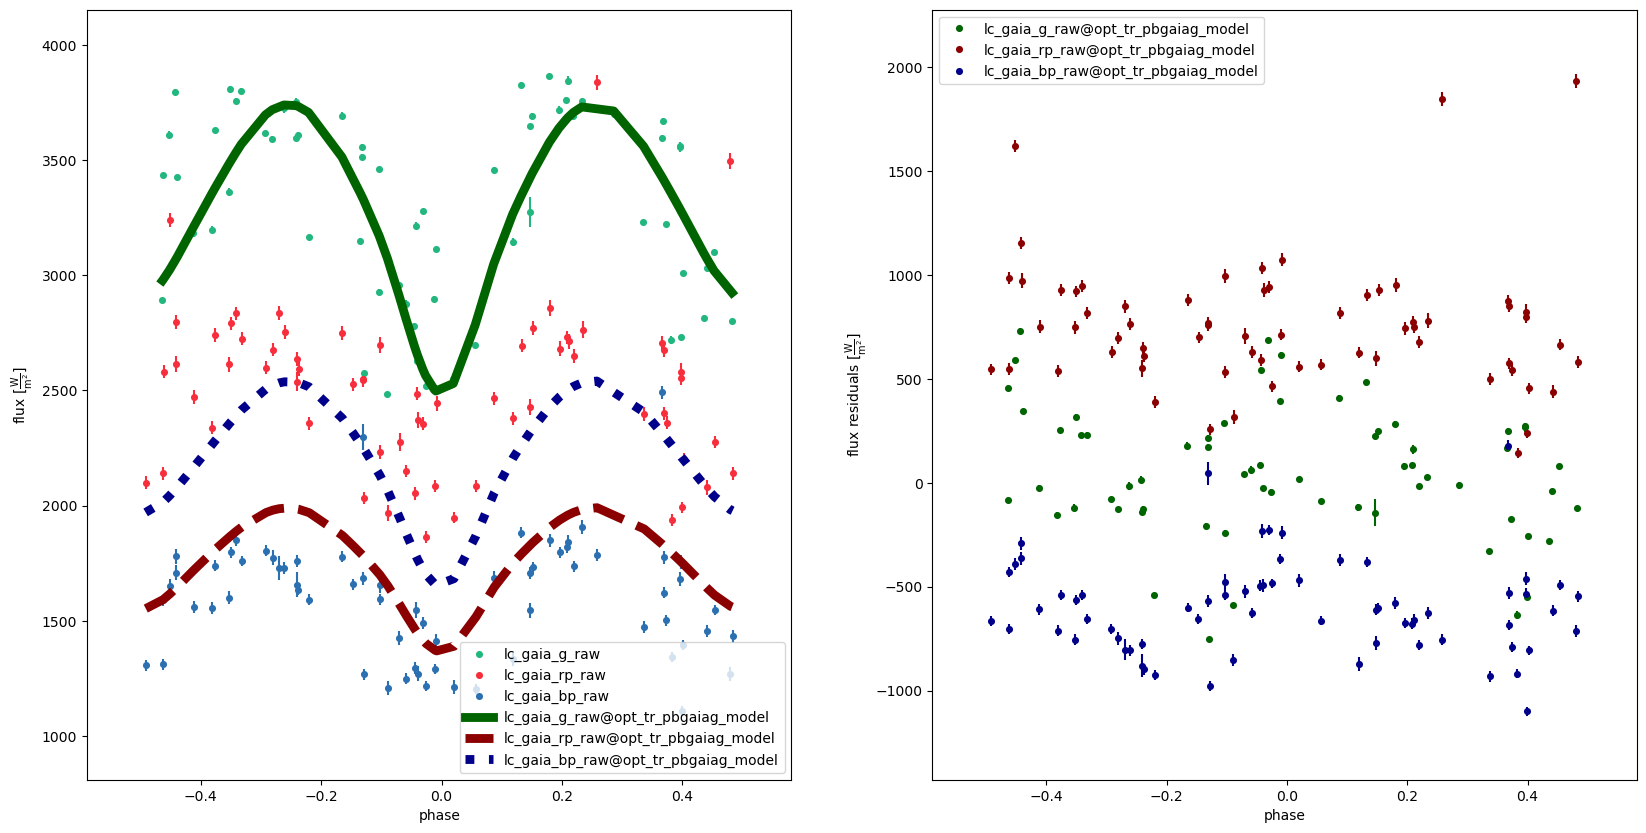

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [55]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/poro-priors-invertq/results/opt_tr_pbgaiag_solution', plot=False, reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=[rawGaiaDatasets], model=computeModelName, color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)
gen_utils.abilitateDatasets(b, b.datasets)

In [10]:
print(b['opt_tr_tprim_pbgaiag'])

ParameterSet: 13 parameters
   comments@opt_tr_tprim_pbgai...: 
   use_server@opt_tr_tprim_pbg...: compute
   compute@opt_tr_tprim_pbgaia...: phoebe01
   expose_lnprobabilities@opt_...: False
   continue_from@opt_tr_tprim_...: None
   fit_parameters@opt_tr_tprim...: ['teffratio', 'teff@primary', 'pblum@lc_gaia_g_raw@primary']
   initial_values@opt_tr_tprim...: {}
   priors@opt_tr_tprim_pbgaiag...: []
   maxiter@opt_tr_tprim_pbgaia...: 500
   adaptive@opt_tr_tprim_pbgai...: False
   xatol@opt_tr_tprim_pbgaiag@...: 0.0001
   fatol@opt_tr_tprim_pbgaiag@...: 0.0001
   progress_every_niters@opt_t...: 1


In [12]:
print(solutionName)
print("-----------------------------------")
print(b[solutionName])

opt_tr_tprim_pbgaiag_solution
-----------------------------------
ParameterSet: 11 parameters
R  fitted_twigs@opt_tr_tprim_p...: ['teffratio@binary@orbit@component' 'teff@primary@star@component'
 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_parameters@opt_tr_tpr...: ['teffratio@binary@orbit@component', 'teff@primary@star@component', 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_distributions@opt_tr_...: False
   adopt_values@opt_tr_tprim_p...: True
R  message@opt_tr_tprim_pbgaia...: Maximum number of iterations has been exceeded.
R  niter@opt_tr_tprim_pbgaiag@...: 200
R  success@opt_tr_tprim_pbgaia...: False
R  initial_values@opt_tr_tprim...: [0.8800597213958596 6000.0 12.566370614359172]
R  fitted_values@opt_tr_tprim_...: [3.6374012789774905 3946.716379427977 445.6315403753456]
R  fitted_units@opt_tr_tprim_p...: ['' 'K' 'W']
   comments@opt_tr_tprim_pbgai...: 


In [22]:
# continuing above gaia pblum optimization, since it did not converge
# TODO: delete in favor of increasing maxiter in previous optimizer
	# including sma@binary as nuisance parameter
print(b['teffratio'])
print(b['teff@primary'])
print(b['pblum@lc_gaia_g_raw'])
print(b['sma@binary'])
# opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@lc_gaia_g_raw@primary', 'sma@binary'], label='tr_tprim_pbgaiag_cont', export=True,
# 						  subfolder='differential-norm-estimates', datasets=rawGaiaDatasets, maxiter=800)
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@lc_gaia_g_raw@primary', 'sma@binary'], label='tr_tprim_pbgaiag_sma_cont', export=True,
						  subfolder='differential-norm-estimates', datasets=rawGaiaDatasets, maxiter=800)

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.9570218776515114
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

Parameter: teff@primary@component
                       Qualifier: teff
                     Description: Mean effective temperature
                           Value: 4070.472467436457 K
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teffratio@binary@component, teff@secondary@component

Parameter: pblum@primary@lc_gaia_g_raw@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 25445.028059731216 W
                

('opt_tr_tprim_pbgaiag_sma_cont', 'opt_tr_tprim_pbgaiag_sma_cont_solution')

Adopted:
teffratio@binary@orbit@component = 0.95675 
teff@primary@star@component = 4071.63126 K
pblum@primary@lc_gaia_g_raw@lc@dataset = 25448.05138 W

Original values:
  teffratio@binary@orbit@component 0.9570218776515114
  teff@primary@star@component 4070.472467436457 K
  pblum@primary@lc_gaia_g_raw@lc@dataset 25445.028059731216 W


100%|██████████| 213/213 [00:25<00:00,  8.44it/s]


--------------------------------
ParameterSet: 11 parameters
R  fitted_twigs@opt_tr_tprim_p...: ['teffratio@binary@orbit@component' 'teff@primary@star@component'
 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_parameters@opt_tr_tpr...: ['teffratio@binary@orbit@component', 'teff@primary@star@component', 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_distributions@opt_tr_...: False
   adopt_values@opt_tr_tprim_p...: True
R  message@opt_tr_tprim_pbgaia...: Optimization terminated successfully.
R  niter@opt_tr_tprim_pbgaiag_...: 166
R  success@opt_tr_tprim_pbgaia...: True
R  initial_values@opt_tr_tprim...: [0.9570218776515114 4070.472467436457 25445.028059731216]
R  fitted_values@opt_tr_tprim_...: [0.9567495065636673 4071.631256157665 25448.05137614302]
R  fitted_units@opt_tr_tprim_p...: ['' 'K' 'W']
   comments@opt_tr_tprim_pbgai...: 


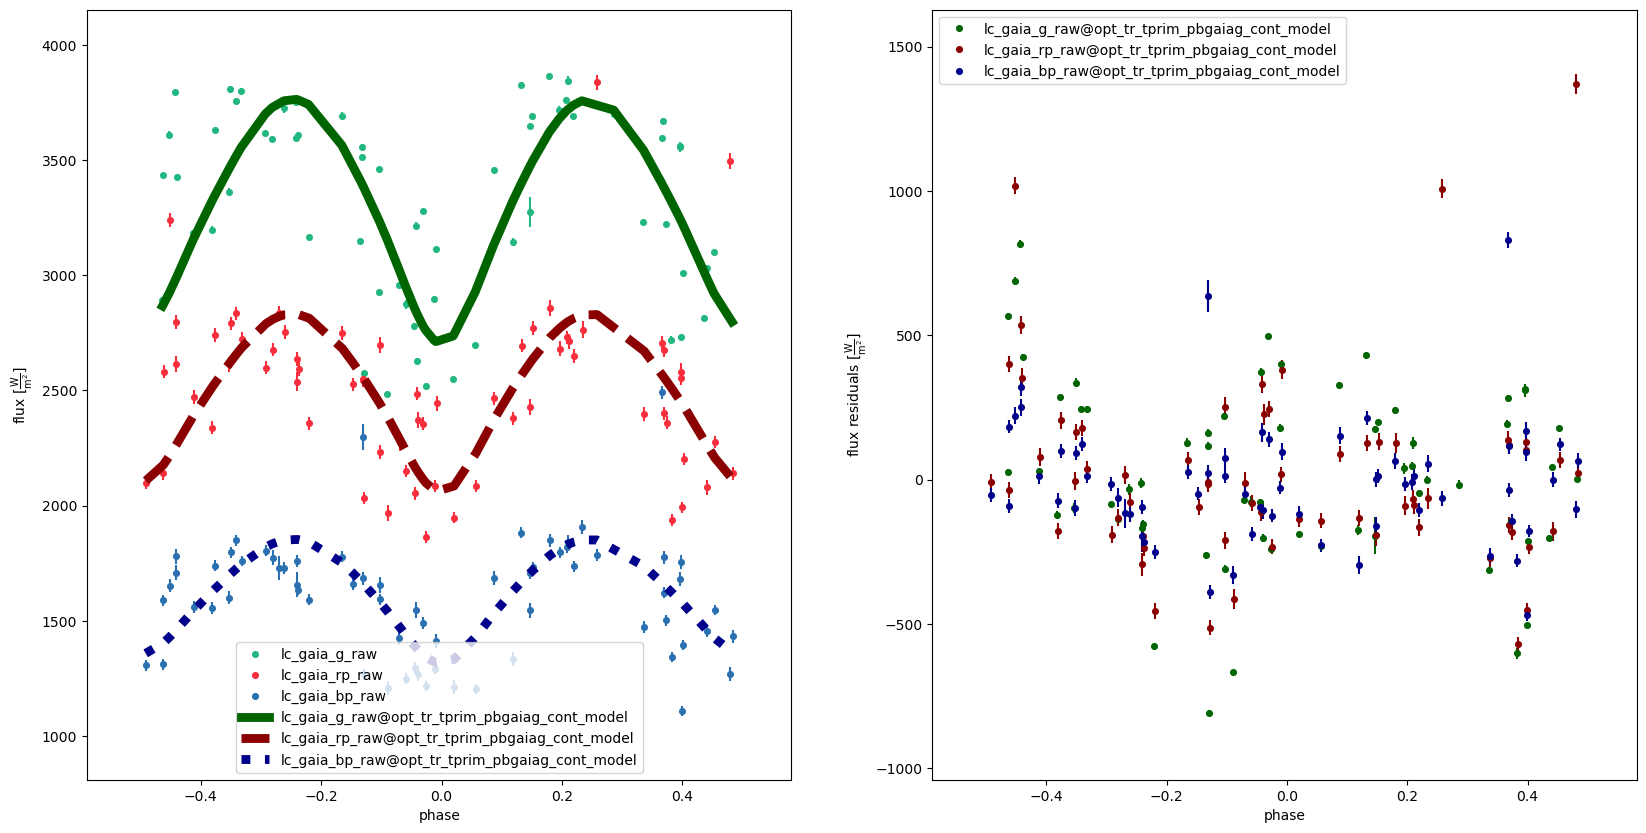

In [19]:
# b.set_value_all(qualifier='enabled', value=True)
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/differential-norm-estimates/results/opt_tr_tprim_pbgaiag_cont_solution', plot=False, reset_params=False)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/differential-norm-estimates/pblum-teff/results/opt_tr_tprim_pbgaiag_sma_cont_solution', plot=False, reset_params=True)
print('--------------------------------')
print(b[solutionName])
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=[rawGaiaDatasets], model=computeModelName, color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)

### Adjust Iturbide `pblum` after determining `teffratio` and `teff@primary` using Gaia LCs

In [16]:
opt_utils.optimize_params(b, label='pblum_iturbide_aftergaia', export=True, subfolder='differential-norm-estimates', 
						  fit_twigs=['pblum@lc_iturbide_raw@primary'], datasets=['lc_iturbide_raw'])

Sun, 01 Oct 2023 20:19 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.


External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_pblum_iturbide_aftergaia.py ./results/opt_pblum_iturbide_aftergaia_solution


('opt_pblum_iturbide_aftergaia', 'opt_pblum_iturbide_aftergaia_solution')

Adopted:
pblum@primary@lc_iturbide_raw@lc@dataset = 403710.44491 W

Original values:
  pblum@primary@lc_iturbide_raw@lc@dataset 465264.61351050576 W


Sun, 01 Oct 2023 23:26 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1217/1217 [03:14<00:00,  6.25it/s]


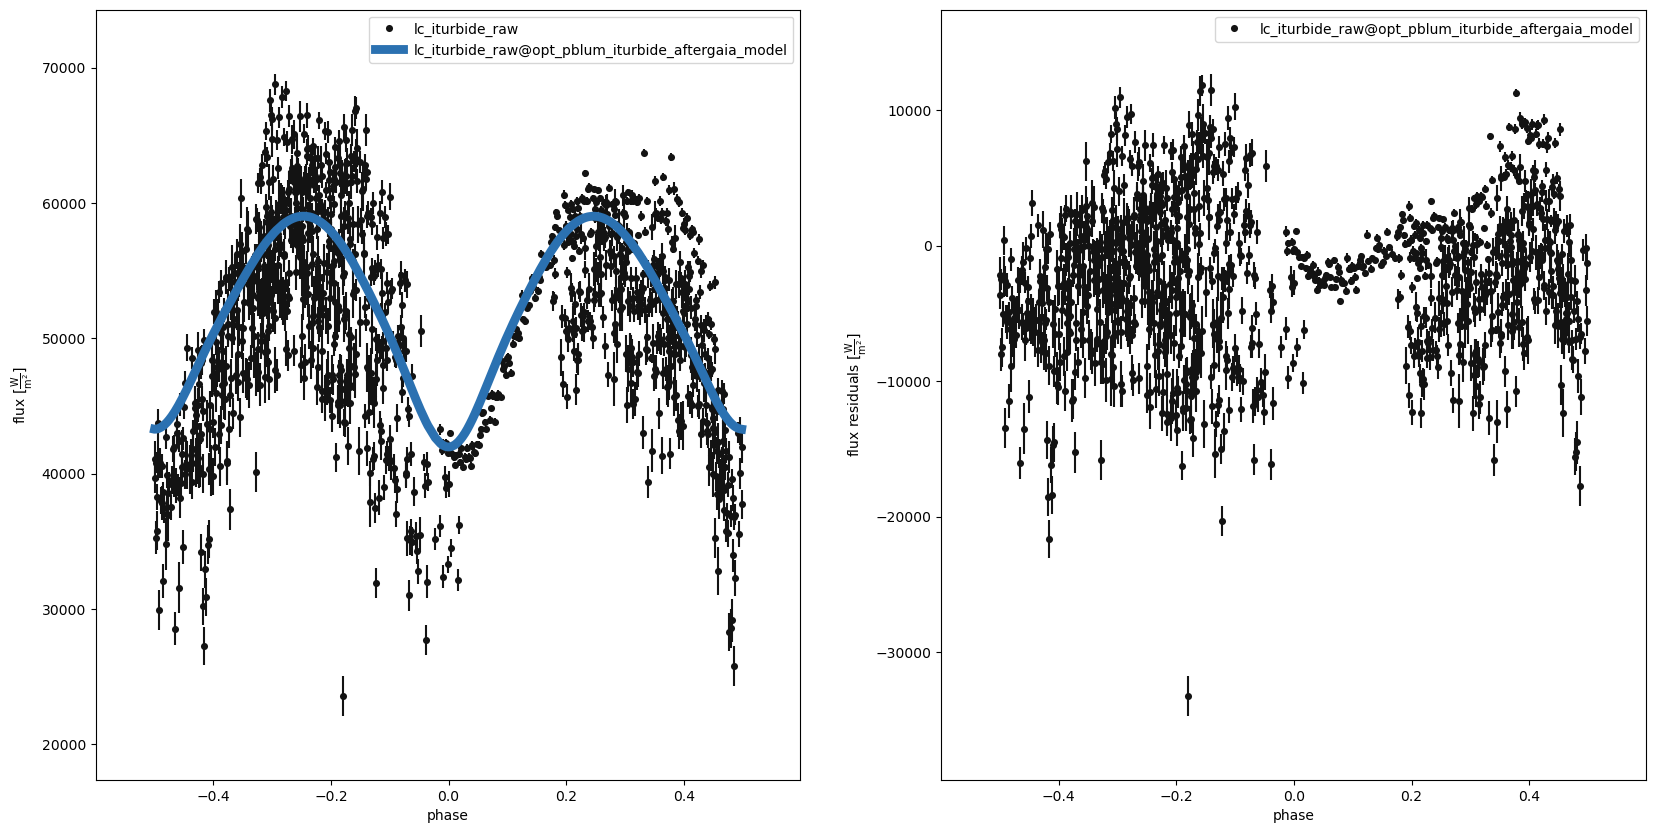

In [39]:
# need to re-optimize for the iturbide passband luminosity, using the teffratio obtained from gaia LCs
gen_utils.abilitateDatasets(b, ['lc_iturbide_raw'])
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/differential-norm-estimates/results/opt_pblum_iturbide_aftergaia_solution', plot=False, reset_params=False)
gen_utils.plotModelResidualsFigsize(b, (20,10), ['lc_iturbide_raw'], model=computeModelName, legend=True, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [27]:
print(b['q'])
print(b['fillout_factor'])
print(b['teffratio'])
print(b['incl@binary'])
print(b['sma@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 0.8367426134047191
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, period@binary@component, mass@primary@component, sma@primary@component, incl@bi

In [18]:
print(b['requiv'])
print(b['mass'])
print(b['teff'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.3787223865791338 solRad
C      requiv@secondary@component: 1.274317656384745 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 4 parameters
C          mass@primary@component: 2.4681019104732327 solMass
C        mass@secondary@component: 2.0651660427185528 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.2062175044193281792104244232

In [29]:
b.models

['before_optimizers',
 'opt_period_t0_model',
 'opt_teffratio_ff_gaiag_model',
 'opt_teffratio_ff_iturbide_model',
 'opt_teffratio_ff_rawdata_model',
 'teffratio_ff',
 'opt_per0_model',
 'opt_per0_iturbide_model',
 'opt_per0_gaia_model',
 'opt_tp_tr_ff_model',
 'before_pblum_opt',
 'opt_tr_tprim_pbgaiag_model',
 'opt_tr_tprim_pbgaiag_cont_model',
 'opt_pblum_iturbide_model']

In [20]:
gen_utils.displayAnims(1, 3, 
	gen_utils.genAnimatedMesh(b, logger, model='opt_tr_tprim_pbgaiag_cont_model', draw_title=True, title="After optimization"),
	gen_utils.genAnimatedMesh(b, logger, model='opt_tr_tprim_pbgaiag_cont_model', component='primary', draw_title=True, title="After optimization - Primary"),
	gen_utils.genAnimatedMesh(b, logger, model='opt_tr_tprim_pbgaiag_cont_model', component='secondary', draw_title=True, title="After optimization - Secondary"))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

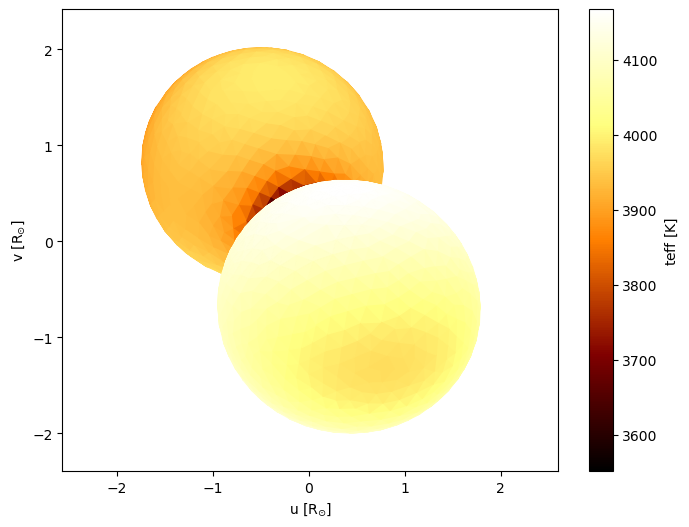

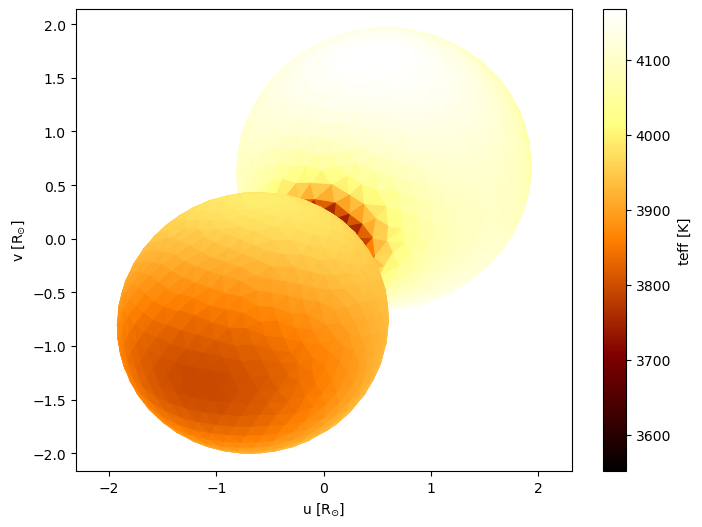

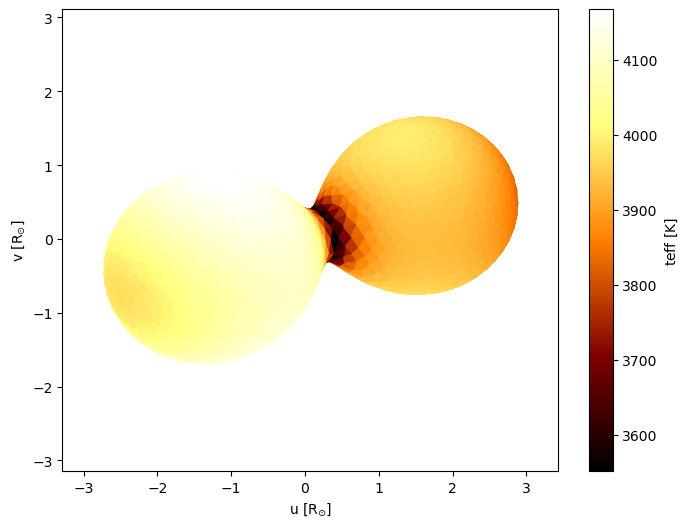

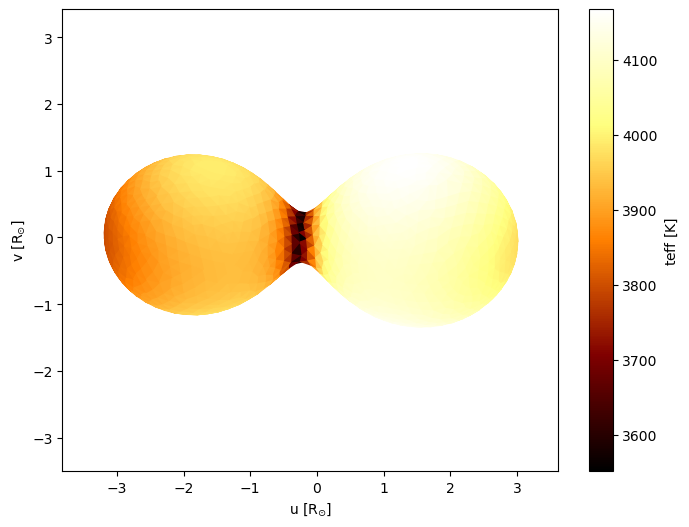

In [38]:
# mesh snapshots for divulgation purposes

logger.setLevel('ERROR')
meshComputeTimes = b.get_value(qualifier='compute_times', dataset='mesh01')
for t in meshComputeTimes[::4]:
	b.plot(dataset='mesh01', fc='teffs', ec='face', model='opt_tr_tprim_pbgaiag_cont_model', time=t, draw_sidebars=True, show=True)
logger.setLevel('WARNING')